<font size="2" color="Black"><b>Authors : Celestine E. Ugwu<b><font><br><font size="2" color="black">Created : December, 2022 <font><br><font size="2" color="Black">
## Warehouse Supply Chain Prediction

The solution is divided into the following sections: 
- Data understanding and exploration
- Data cleaning
- Data preparation
- Model building and evaluation
 <font> 
<div align="center"> <font size="2" color="red"><b><!--# For Citi Internal training purpose only #--></b></font> </div>

In [1]:
#Data Manipulation and handeling
import pandas as pd
import numpy as np
from scipy.stats import chi2_contingency
import scipy.stats as stats
import statsmodels.api as sm
from statsmodels.formula.api import ols

#Data Visualization Libraries
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as sci

#Data Preprocessing and EDA Libraries
from collections import OrderedDict
from sklearn.preprocessing import StandardScaler

#Model Selection Libraries
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, learning_curve

#ML Models
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
import xgboost
from xgboost import XGBRegressor

#Model Evaluation Libraries
from sklearn.metrics import r2_score, mean_squared_error

#Unsupervised ML library
from sklearn.cluster import KMeans


#Warning filter library
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_excel('supplychain train dataset.xlsx')
#pd.set_option('display.max_columns',None)
df.head()

,Ware_house_ID,WH_Manager_ID,Location_type,WH_capacity_size,zone,WH_regional_zone,num_refill_req_l3m,transport_issue_l1y,Competitor_in_mkt,retail_shop_num,...,electric_supply,dist_from_hub,workers_num,wh_est_year,storage_issue_reported_l3m,temp_reg_mach,approved_wh_govt_certificate,wh_breakdown_l3m,govt_check_l3m,product_wg_ton
0,WH_100000,EID_50000,Urban,Small,West,Zone 6,3,1,2,4651,...,1,91,29.0,NaN,13,0,A,5,15,17115
1,WH_100001,EID_50001,Rural,Large,North,Zone 5,0,0,4,6217,...,1,210,31.0,NaN,4,0,A,3,17,5074
2,WH_100002,EID_50002,Rural,Mid,South,Zone 2,1,0,4,4306,...,0,161,37.0,NaN,17,0,A,6,22,23137
3,WH_100003,EID_50003,Rural,Mid,North,Zone 3,7,4,2,6000,...,0,103,21.0,NaN,17,1,A+,3,27,22115
4,WH_100004,EID_50004,Rural,Large,North,Zone 5,3,1,2,4740,...,1,112,25.0,2009.0,18,0,C,6,24,24071


In [3]:
df_numeric = df.select_dtypes(include=['float64', 'int64'])
df_numeric.head()

,num_refill_req_l3m,transport_issue_l1y,Competitor_in_mkt,retail_shop_num,distributor_num,flood_impacted,flood_proof,electric_supply,dist_from_hub,workers_num,wh_est_year,storage_issue_reported_l3m,temp_reg_mach,wh_breakdown_l3m,govt_check_l3m,product_wg_ton
0,3,1,2,4651,24,0,1,1,91,29.0,NaN,13,0,5,15,17115
1,0,0,4,6217,47,0,0,1,210,31.0,NaN,4,0,3,17,5074
2,1,0,4,4306,64,0,0,0,161,37.0,NaN,17,0,6,22,23137
3,7,4,2,6000,50,0,0,0,103,21.0,NaN,17,1,3,27,22115
4,3,1,2,4740,42,1,0,1,112,25.0,2009.0,18,0,6,24,24071


In [4]:
df_char = df.select_dtypes(include=['object'])
df_char.head()

,Ware_house_ID,WH_Manager_ID,Location_type,WH_capacity_size,zone,WH_regional_zone,wh_owner_type,approved_wh_govt_certificate
0,WH_100000,EID_50000,Urban,Small,West,Zone 6,Rented,A
1,WH_100001,EID_50001,Rural,Large,North,Zone 5,Company Owned,A
2,WH_100002,EID_50002,Rural,Mid,South,Zone 2,Company Owned,A
3,WH_100003,EID_50003,Rural,Mid,North,Zone 3,Rented,A+
4,WH_100004,EID_50004,Rural,Large,North,Zone 5,Company Owned,C


##  Correlation Analysis for Categorical Features

        1. Hypothesis test usning Chi square
        2. Bi variate analysis using barplot - visualization

### Chi Square Test for independence

    Null hypothesis: Both variables (independent and dependent)  are not related
    Alternate hypothesis: Both variables are correlated

In [5]:
def chi2test_summary(my_df):
    result = [] 
    for col in my_df.columns:
        if my_df[col].dtypes == 'object':
            contigency= pd.crosstab(my_df[col], my_df['product_wg_ton']) 
            c, p, dof, expected = chi2_contingency(contigency)
            stats = OrderedDict({
                'Feature Name': col,
                'P_Value': p,
                'Chi2_Value': c,
                'Dof_value': dof
                })        
            result.append(stats)
    result_df = pd.DataFrame(result)
    #Hypothesis Result
    acceptance_label = []
    for i in result_df['P_Value']:
        if i > 0.05:
            acceptance_label.append('Null Hypothesis Accepted')
        else:
            acceptance_label.append('Alternate Hypothesis Accepted')
    result_df['Acceptance Comment'] = acceptance_label
    dependency_label = []
    for i in result_df['P_Value']:
        if i > 0.05:
            dependency_label.append('Variables are Independent')
        else:
            dependency_label.append('Variables are dependent ')
    result_df['Correlation Comment'] = dependency_label
    
                   
    return result_df

In [6]:
chi2test_summary(df)

,Feature Name,P_Value,Chi2_Value,Dof_value,Acceptance Comment,Correlation Comment
0,Ware_house_ID,3.752074e-01,9.925415e+07,99249669,Null Hypothesis Accepted,Variables are Independent
1,WH_Manager_ID,3.752074e-01,9.925415e+07,99249669,Null Hypothesis Accepted,Variables are Independent
2,Location_type,3.587164e-03,4.739681e+03,4481,Alternate Hypothesis Accepted,Variables are dependent
3,WH_capacity_size,1.085324e-01,9.127602e+03,8962,Null Hypothesis Accepted,Variables are Independent
4,zone,7.412437e-02,1.368078e+04,13443,Null Hypothesis Accepted,Variables are Independent
5,WH_regional_zone,7.040504e-01,2.229105e+04,22405,Null Hypothesis Accepted,Variables are Independent
6,wh_owner_type,8.570908e-01,4.380057e+03,4481,Null Hypothesis Accepted,Variables are Independent
7,approved_wh_govt_certificate,2.896098e-15,1.893020e+04,17432,Alternate Hypothesis Accepted,Variables are dependent


### Analysis from the Chi square Test Summary Table

    1. Four of the categorical features(Location_type and approved_wh_govt_certificate) have 
    p_value less than 5%, that reject the null hypothesis and gives clue of correlation between them and the target feature.
    2. The remaining  features have p_ value greater than 5% - no correlation with the target variable

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
from numpy import mean

#for col in (df_char.columns):
    #plt.figure()
    #sns.barplot(x=col, y="product_wg_ton",data = df,estimator = mean)
#plt.show()

### Summary from the Barplot

    1. slightly positive correlation exist between Location_type and the target variable
    2. slightly positive correlation exist between approved_wh_govt_certificate and the target variable

## Correlation Analysis For Numerical Features

    1. Hypothesis Test using Anova
    2. Bivariate analysis using regression plot -visualization
    3. Correlation function
    

### Anova Test

    Null hypothesis: Both variables(dependent and independent) are not related
    Alternate hypothesis: Both variables are correlated


In [8]:
def anovatest_summary(my_df):
    table = [] 
    for col in my_df.columns:
        if my_df[col].dtypes != 'object':
            if col != 'product_wg_ton':
                model = ols('product_wg_ton ~ {}'.format(col), data=my_df).fit()
                anova_table = sm.stats.anova_lm(model, typ=2)
     
            table.append(anova_table)
    df_anova = pd.concat(table)
    df_anova.drop(['Residual'], axis=0,inplace=True)
    acceptance_label = []
    for i in df_anova['PR(>F)']:
        if i > 0.05:
            acceptance_label.append('Null Hypothesis Accepted')
        else:
            acceptance_label.append('Alternate Hypothesis Accepted')
    df_anova['Acceptance Comment'] = acceptance_label
    dependency_label = []
    for i in df_anova['PR(>F)']:
        if i > 0.05:
            dependency_label.append('Variables are Independent')
        else:
            dependency_label.append('Variables are dependent ')
    df_anova['Correlation Comment'] = dependency_label
    
    
                   
    return df_anova

In [9]:
anovatest_summary(df)

,sum_sq,df,F,PR(>F),Acceptance Comment,Correlation Comment
num_refill_req_l3m,1.367199e+06,1.0,0.010114,9.198927e-01,Null Hypothesis Accepted,Variables are Independent
transport_issue_l1y,9.246983e+10,1.0,705.879962,3.942661e-153,Alternate Hypothesis Accepted,Variables are dependent
Competitor_in_mkt,1.587563e+08,1.0,1.174517,2.784868e-01,Null Hypothesis Accepted,Variables are Independent
retail_shop_num,1.378374e+08,1.0,1.019747,3.125901e-01,Null Hypothesis Accepted,Variables are Independent
distributor_num,7.918528e+07,1.0,0.585816,4.440497e-01,Null Hypothesis Accepted,Variables are Independent
flood_impacted,7.651049e+07,1.0,0.566027,4.518498e-01,Null Hypothesis Accepted,Variables are Independent
flood_proof,3.808903e+07,1.0,0.281780,5.955420e-01,Null Hypothesis Accepted,Variables are Independent
electric_supply,1.575806e+06,1.0,0.011658,9.140203e-01,Null Hypothesis Accepted,Variables are Independent
dist_from_hub,1.092206e+08,1.0,0.808027,3.687140e-01,Null Hypothesis Accepted,Variables are Independent
workers_num,1.752581e+08,1.0,1.294263,2.552766e-01,Null Hypothesis Accepted,Variables are Independent


### Summary from the Anova Test

        1. There is statistically significant differences in mean of four of the numerical         features(transport_issue_l1y,wh_est_year,storage_issue_reported_l3m and wh_breakdown_l3m) and the target variable
        2. Hence, the above four features are related to the target variable by the outcome of the anova test(p_value<0.05)
        3. The remaining features have insignificant effect on the target variable (P_value > 0.05)

### Bi Variate Analysis using Regression Plot 

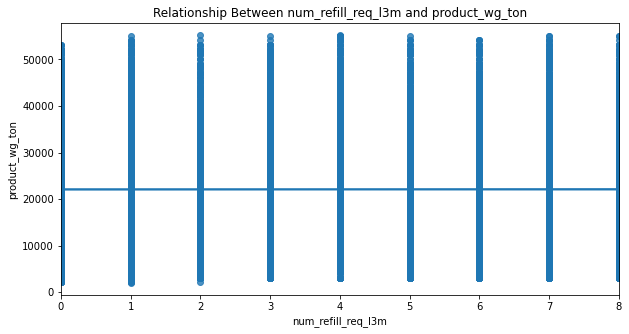

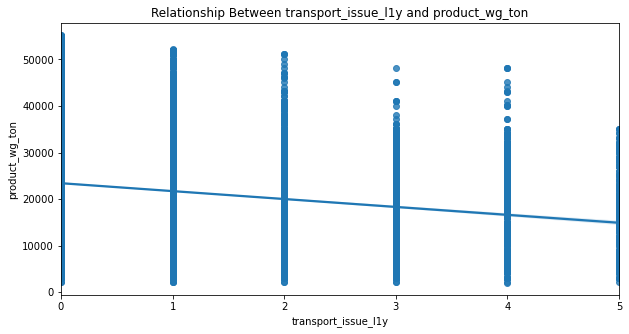

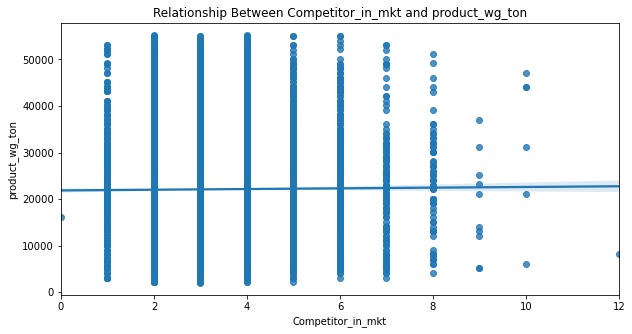

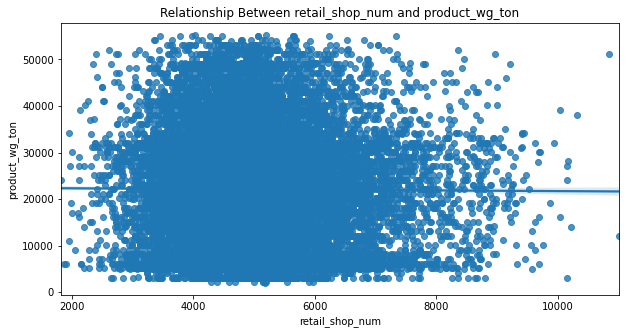

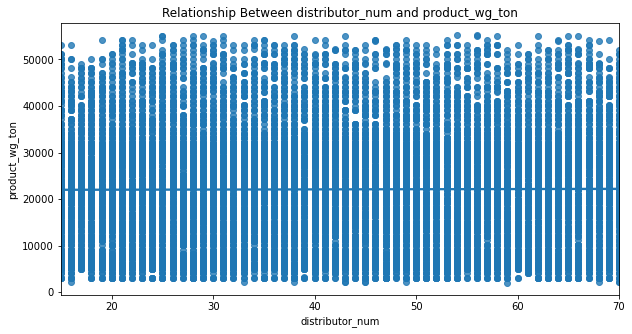

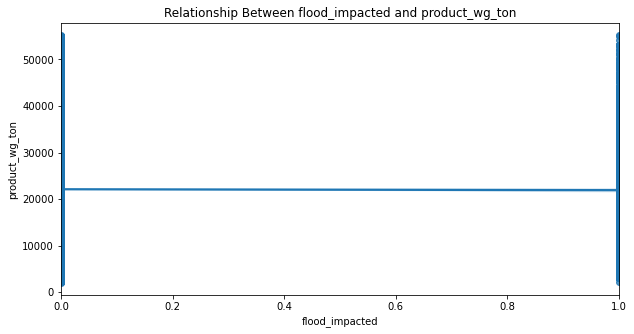

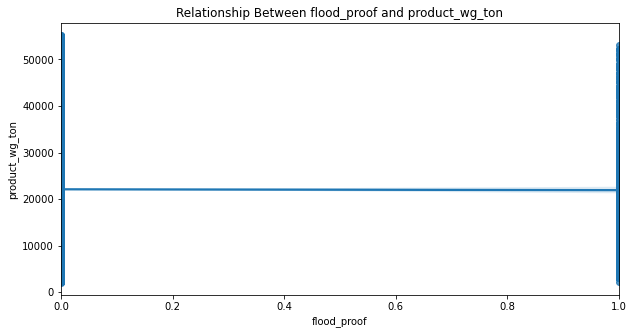

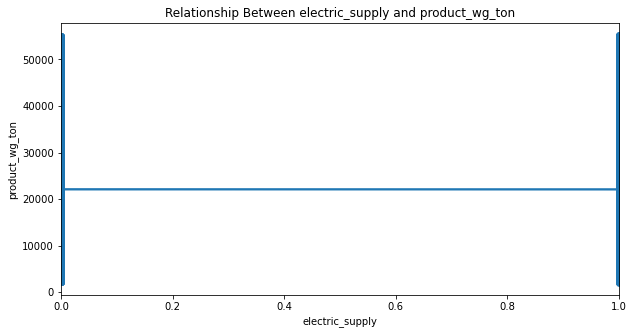

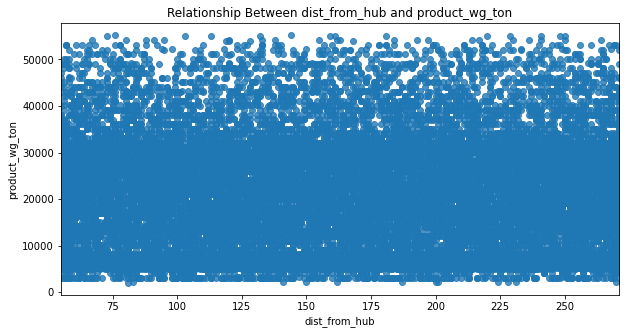

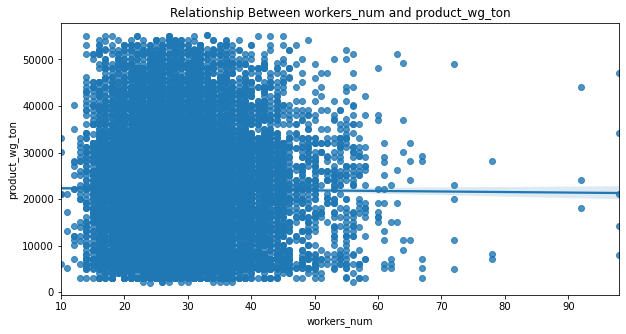

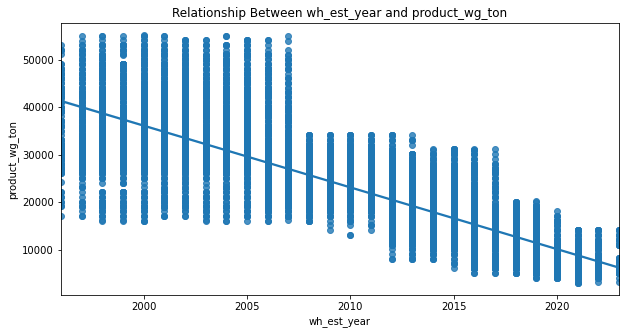

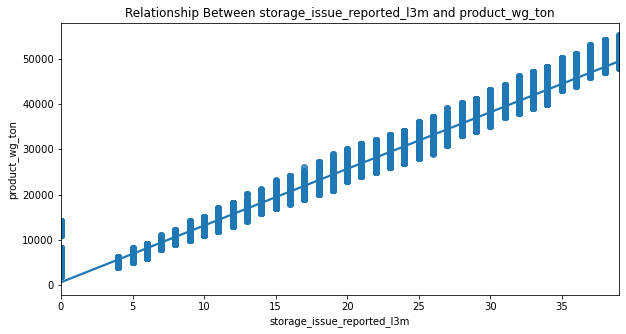

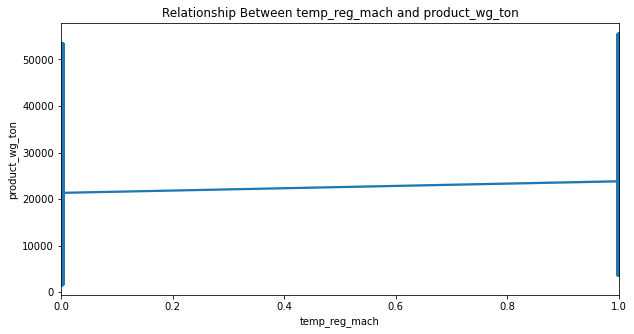

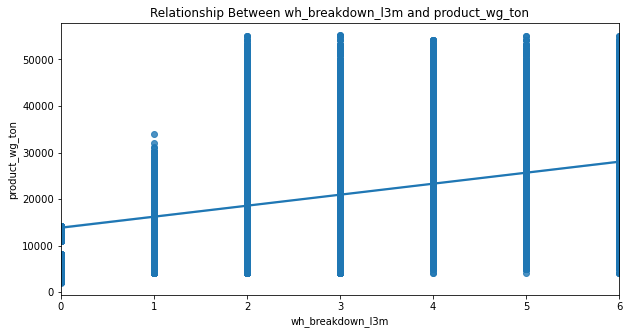

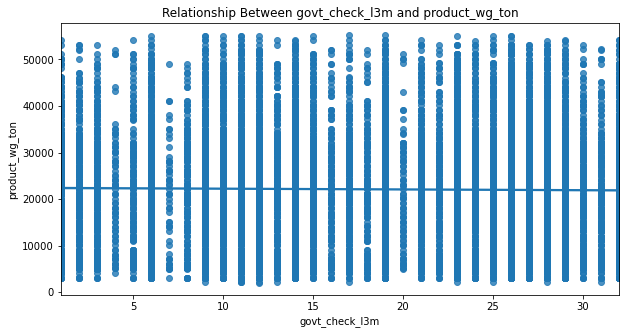

In [10]:
for col in df_numeric.columns:
    if col != 'product_wg_ton':
        fig , ax1 = plt.subplots(figsize = (10,5))
        sns.regplot(x = df[col] , y = df['product_wg_ton'] , ax = ax1).set_title(f'Relationship Between {col} and product_wg_ton')
                                            

### Summary from the Regression Plot

    1. Four of the numerical features are seen to be correlated.
    2. wh_est_year is highly negatively correlated to the target variable
    3. storage_issue_reported_l3m is highly positively correlated to the target variaible
    4. wh_breakdown_l3m is slightly positively correlated and transport_issue_l1y slightly negatively correlated.
    5. The rest have no significant correlation with the target variable

### Correlation Function

In [11]:
def correlation_with_tagret(data, t_col):
    independent_variable = data.drop(t_col, axis =1).columns
    corr_result = []
    for col in independent_variable:
        corr_result.append(data[t_col].corr(data[col]))
    result = pd.DataFrame([independent_variable, corr_result], index= ['Independent Variables', 'correlation']).T
    return result.sort_values('correlation', ascending = False)

In [12]:
correlation_with_tagret(df_numeric, 'product_wg_ton')

,Independent Variables,correlation
11,storage_issue_reported_l3m,0.986796
13,wh_breakdown_l3m,0.343677
12,temp_reg_mach,0.098452
2,Competitor_in_mkt,0.007282
4,distributor_num,0.005143
0,num_refill_req_l3m,0.000676
7,electric_supply,-0.000725
6,flood_proof,-0.003567
5,flood_impacted,-0.005055
8,dist_from_hub,-0.00604


### Summary from  the Correlation function¶

    1. storage_issue_reported_l3m and wh_est_year have strong correlation with product_wg_ton
    2. wh_breakdown_l3m and transport_issue_l1y have slight correlation with product_wg_ton

## Exploratory Data Analysis(EDA)

In [13]:
df.shape

(22150, 24)

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22150 entries, 0 to 22149
Data columns (total 24 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Ware_house_ID                 22150 non-null  object 
 1   WH_Manager_ID                 22150 non-null  object 
 2   Location_type                 22150 non-null  object 
 3   WH_capacity_size              22150 non-null  object 
 4   zone                          22150 non-null  object 
 5   WH_regional_zone              22150 non-null  object 
 6   num_refill_req_l3m            22150 non-null  int64  
 7   transport_issue_l1y           22150 non-null  int64  
 8   Competitor_in_mkt             22150 non-null  int64  
 9   retail_shop_num               22150 non-null  int64  
 10  wh_owner_type                 22150 non-null  object 
 11  distributor_num               22150 non-null  int64  
 12  flood_impacted                22150 non-null  int64  
 13  f

In [15]:
df.isnull().sum()

Ware_house_ID                       0
WH_Manager_ID                       0
Location_type                       0
WH_capacity_size                    0
zone                                0
WH_regional_zone                    0
num_refill_req_l3m                  0
transport_issue_l1y                 0
Competitor_in_mkt                   0
retail_shop_num                     0
wh_owner_type                       0
distributor_num                     0
flood_impacted                      0
flood_proof                         0
electric_supply                     0
dist_from_hub                       0
workers_num                       877
wh_est_year                     10545
storage_issue_reported_l3m          0
temp_reg_mach                       0
approved_wh_govt_certificate      805
wh_breakdown_l3m                    0
govt_check_l3m                      0
product_wg_ton                      0
dtype: int64

In [16]:
a = df.isna().sum()
perc = (a/len(df))*100
perc

Ware_house_ID                    0.000000
WH_Manager_ID                    0.000000
Location_type                    0.000000
WH_capacity_size                 0.000000
zone                             0.000000
WH_regional_zone                 0.000000
num_refill_req_l3m               0.000000
transport_issue_l1y              0.000000
Competitor_in_mkt                0.000000
retail_shop_num                  0.000000
wh_owner_type                    0.000000
distributor_num                  0.000000
flood_impacted                   0.000000
flood_proof                      0.000000
electric_supply                  0.000000
dist_from_hub                    0.000000
workers_num                      3.959368
wh_est_year                     47.607223
storage_issue_reported_l3m       0.000000
temp_reg_mach                    0.000000
approved_wh_govt_certificate     3.634312
wh_breakdown_l3m                 0.000000
govt_check_l3m                   0.000000
product_wg_ton                   0

#### Observations from df.info() and df.isnull().sum()

    1. There are 877 null values in workers_num feature
    2. There are 10545 null values in wh_est_year feature
    3. There are 805 null values in approved_wh_govt_certificate feature
    4. The remaining independent features have no null values
    5. There are 23 independent features and one target feature - product_wg_ton
    6. 8 features have object datatypes, 14 int64 and 2 have float64 as datatype
    7. There are 22150 rows and 24 columns

In [17]:
df.describe()

,num_refill_req_l3m,transport_issue_l1y,Competitor_in_mkt,retail_shop_num,distributor_num,flood_impacted,flood_proof,electric_supply,dist_from_hub,workers_num,wh_est_year,storage_issue_reported_l3m,temp_reg_mach,wh_breakdown_l3m,govt_check_l3m,product_wg_ton
count,22150.000000,22150.000000,22150.000000,22150.000000,22150.000000,22150.000000,22150.000000,22150.000000,22150.000000,21273.000000,11605.000000,22150.000000,22150.000000,22150.000000,22150.000000,22150.000000
mean,4.097020,0.777201,3.103928,4983.115711,42.386998,0.098691,0.054492,0.656072,163.613725,28.936398,2009.401206,17.116659,0.304199,3.487765,18.767765,22086.780813
std,2.606289,1.201747,1.142886,1050.634225,16.057730,0.298253,0.226991,0.475028,62.660709,7.843431,7.527223,9.174193,0.460078,1.691661,8.644778,11626.192340
min,0.000000,0.000000,0.000000,1821.000000,15.000000,0.000000,0.000000,0.000000,55.000000,10.000000,1996.000000,0.000000,0.000000,0.000000,1.000000,2065.000000
25%,2.000000,0.000000,2.000000,4309.250000,29.000000,0.000000,0.000000,0.000000,109.000000,24.000000,2003.000000,10.000000,0.000000,2.000000,11.000000,12151.000000
50%,4.000000,0.000000,3.000000,4859.000000,42.000000,0.000000,0.000000,1.000000,164.000000,28.000000,2009.000000,18.000000,0.000000,3.000000,20.000000,22099.000000
75%,6.000000,1.000000,4.000000,5499.000000,56.000000,0.000000,0.000000,1.000000,218.000000,33.000000,2016.000000,24.000000,1.000000,5.000000,26.000000,30102.000000
max,8.000000,5.000000,12.000000,11008.000000,70.000000,1.000000,1.000000,1.000000,271.000000,98.000000,2023.000000,39.000000,1.000000,6.000000,32.000000,55151.000000


### Analysis from Descriptive Analysis 

    1. There might be skewness in the data in the columns
    2. There might be chance of outliers if we compare Quartiles of some of the columns(transport_issue_l1y,Competitor_in_mkt,workers_num) in the upper whisker
    3. Since minimum and Q1 values are same for transport_issue_l1y we do not have outliers in the Lower Whisker region for it.

## Handling missing values

In [18]:
df = pd.read_excel('supplychain train dataset.xlsx')
cols = ['product_wg_ton', 'wh_est_year']
x = df[cols]
x

,product_wg_ton,wh_est_year
0,17115,NaN
1,5074,NaN
2,23137,NaN
3,22115,NaN
4,24071,2009.0
...,...,...
22145,29138,2007.0
22146,33108,NaN
22147,24072,NaN
22148,15055,NaN


In [19]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

impute_it = IterativeImputer()
df1 = impute_it.fit_transform(x)
df1

array([[17115.        ,  2012.98178842],
       [ 5074.        ,  2019.33719361],
       [23137.        ,  2009.80329411],
       ...,
       [24072.        ,  2009.30978826],
       [15055.        ,  2014.06908472],
       [14103.        ,  2014.57156339]])

In [20]:
df1 = pd.DataFrame(df1, columns = ['weight', 'year'])
df1

,weight,year
0,17115.0,2012.981788
1,5074.0,2019.337194
2,23137.0,2009.803294
3,22115.0,2010.342720
4,24071.0,2009.000000
...,...,...
22145,29138.0,2007.000000
22146,33108.0,2004.540463
22147,24072.0,2009.309788
22148,15055.0,2014.069085


In [21]:
df['wh_est_year'] = df1['year']
df['wh_est_year'] = df['wh_est_year'].astype('int64')
df

,Ware_house_ID,WH_Manager_ID,Location_type,WH_capacity_size,zone,WH_regional_zone,num_refill_req_l3m,transport_issue_l1y,Competitor_in_mkt,retail_shop_num,...,electric_supply,dist_from_hub,workers_num,wh_est_year,storage_issue_reported_l3m,temp_reg_mach,approved_wh_govt_certificate,wh_breakdown_l3m,govt_check_l3m,product_wg_ton
0,WH_100000,EID_50000,Urban,Small,West,Zone 6,3,1,2,4651,...,1,91,29.0,2012,13,0,A,5,15,17115
1,WH_100001,EID_50001,Rural,Large,North,Zone 5,0,0,4,6217,...,1,210,31.0,2019,4,0,A,3,17,5074
2,WH_100002,EID_50002,Rural,Mid,South,Zone 2,1,0,4,4306,...,0,161,37.0,2009,17,0,A,6,22,23137
3,WH_100003,EID_50003,Rural,Mid,North,Zone 3,7,4,2,6000,...,0,103,21.0,2010,17,1,A+,3,27,22115
4,WH_100004,EID_50004,Rural,Large,North,Zone 5,3,1,2,4740,...,1,112,25.0,2009,18,0,C,6,24,24071
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22145,WH_122145,EID_72145,Rural,Large,North,Zone 6,8,1,3,5030,...,1,203,28.0,2007,22,1,A+,2,4,29138
22146,WH_122146,EID_72146,Rural,Small,South,Zone 6,3,1,3,4320,...,0,170,NaN,2004,26,0,C,5,9,33108
22147,WH_122147,EID_72147,Rural,Large,North,Zone 6,7,2,2,5268,...,0,99,22.0,2009,20,0,B+,6,4,24072
22148,WH_122148,EID_72148,Rural,Large,North,Zone 6,6,2,4,4378,...,0,220,17.0,2014,13,0,B,3,28,15055


In [22]:
df['approved_wh_govt_certificate'] = df['approved_wh_govt_certificate'].fillna(df['approved_wh_govt_certificate'].mode()[0])
df['workers_num']= df['workers_num'].fillna(df['workers_num'].median())
df['workers_num'] = df['workers_num'].astype('int64')


In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22150 entries, 0 to 22149
Data columns (total 24 columns):
 #   Column                        Non-Null Count  Dtype 
---  ------                        --------------  ----- 
 0   Ware_house_ID                 22150 non-null  object
 1   WH_Manager_ID                 22150 non-null  object
 2   Location_type                 22150 non-null  object
 3   WH_capacity_size              22150 non-null  object
 4   zone                          22150 non-null  object
 5   WH_regional_zone              22150 non-null  object
 6   num_refill_req_l3m            22150 non-null  int64 
 7   transport_issue_l1y           22150 non-null  int64 
 8   Competitor_in_mkt             22150 non-null  int64 
 9   retail_shop_num               22150 non-null  int64 
 10  wh_owner_type                 22150 non-null  object
 11  distributor_num               22150 non-null  int64 
 12  flood_impacted                22150 non-null  int64 
 13  flood_proof     

In [24]:
df.isnull().sum()

Ware_house_ID                   0
WH_Manager_ID                   0
Location_type                   0
WH_capacity_size                0
zone                            0
WH_regional_zone                0
num_refill_req_l3m              0
transport_issue_l1y             0
Competitor_in_mkt               0
retail_shop_num                 0
wh_owner_type                   0
distributor_num                 0
flood_impacted                  0
flood_proof                     0
electric_supply                 0
dist_from_hub                   0
workers_num                     0
wh_est_year                     0
storage_issue_reported_l3m      0
temp_reg_mach                   0
approved_wh_govt_certificate    0
wh_breakdown_l3m                0
govt_check_l3m                  0
product_wg_ton                  0
dtype: int64

### Checking the unique values of Numerical Features

In [25]:
df['flood_proof'].astype('int64').value_counts()

0    20943
1     1207
Name: flood_proof, dtype: int64

In [26]:
df['flood_impacted'].astype('int64').value_counts()

0    19964
1     2186
Name: flood_impacted, dtype: int64

In [27]:
df['electric_supply'].astype('int64').value_counts()

1    14532
0     7618
Name: electric_supply, dtype: int64

In [28]:
df['temp_reg_mach'].astype('int64').value_counts()

0    15412
1     6738
Name: temp_reg_mach, dtype: int64

In [29]:
df['wh_breakdown_l3m'].astype('int64').value_counts()

2    4481
3    4417
4    3585
6    3579
5    3486
1    1797
0     805
Name: wh_breakdown_l3m, dtype: int64

In [30]:
df['transport_issue_l1y'].astype('int64').value_counts()

0    13448
1     4127
2     1947
3     1633
4      680
5      315
Name: transport_issue_l1y, dtype: int64

In [31]:
df['Competitor_in_mkt'].astype('int64').value_counts()

2     7719
3     6263
4     5930
5     1120
6      493
1      372
7      167
8       68
9       10
10       6
0        1
12       1
Name: Competitor_in_mkt, dtype: int64

In [32]:
df['num_refill_req_l3m'].astype('int64').value_counts()

5    2651
8    2642
3    2618
0    2583
7    2541
4    2513
1    2503
6    2491
2    1608
Name: num_refill_req_l3m, dtype: int64

#### Observations from the above analysis

    1. Each of the eight numerical features has discrete levels of less than 20
    2. As a result, they will be merged with categorical features in this analysis

In [33]:
#Converting the features' dtypes to object since they have discrete values of less than 20 levels

df['temp_reg_mach'] = df['temp_reg_mach'].astype('object')
df['electric_supply'] = df['electric_supply'].astype('object')
df['flood_impacted'] = df['flood_impacted'].astype('object')
df['flood_proof'] = df['flood_proof'].astype('object')
df['num_refill_req_l3m'] = df['num_refill_req_l3m'].astype('object')
df['Competitor_in_mkt'] = df['Competitor_in_mkt'].astype('object')
df['transport_issue_l1y'] = df['transport_issue_l1y'].astype('object')
df['wh_breakdown_l3m'] = df['wh_breakdown_l3m'].astype('object')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22150 entries, 0 to 22149
Data columns (total 24 columns):
 #   Column                        Non-Null Count  Dtype 
---  ------                        --------------  ----- 
 0   Ware_house_ID                 22150 non-null  object
 1   WH_Manager_ID                 22150 non-null  object
 2   Location_type                 22150 non-null  object
 3   WH_capacity_size              22150 non-null  object
 4   zone                          22150 non-null  object
 5   WH_regional_zone              22150 non-null  object
 6   num_refill_req_l3m            22150 non-null  object
 7   transport_issue_l1y           22150 non-null  object
 8   Competitor_in_mkt             22150 non-null  object
 9   retail_shop_num               22150 non-null  int64 
 10  wh_owner_type                 22150 non-null  object
 11  distributor_num               22150 non-null  int64 
 12  flood_impacted                22150 non-null  object
 13  flood_proof     

### Drop ID Features from the dataset

In [34]:
#Dropping ID features beacuse of high variance among the datapoints
df = df.drop(['Ware_house_ID','WH_Manager_ID'], axis = 1)

In [35]:
df_numeric = df.select_dtypes(include=['float64', 'int64'])
df_numeric.head()

,retail_shop_num,distributor_num,dist_from_hub,workers_num,wh_est_year,storage_issue_reported_l3m,govt_check_l3m,product_wg_ton
0,4651,24,91,29,2012,13,15,17115
1,6217,47,210,31,2019,4,17,5074
2,4306,64,161,37,2009,17,22,23137
3,6000,50,103,21,2010,17,27,22115
4,4740,42,112,25,2009,18,24,24071


In [36]:
df_char = df.select_dtypes(include=['object'])
df_char.head()

,Location_type,WH_capacity_size,zone,WH_regional_zone,num_refill_req_l3m,transport_issue_l1y,Competitor_in_mkt,wh_owner_type,flood_impacted,flood_proof,electric_supply,temp_reg_mach,approved_wh_govt_certificate,wh_breakdown_l3m
0,Urban,Small,West,Zone 6,3,1,2,Rented,0,1,1,0,A,5
1,Rural,Large,North,Zone 5,0,0,4,Company Owned,0,0,1,0,A,3
2,Rural,Mid,South,Zone 2,1,0,4,Company Owned,0,0,0,0,A,6
3,Rural,Mid,North,Zone 3,7,4,2,Rented,0,0,0,1,A+,3
4,Rural,Large,North,Zone 5,3,1,2,Company Owned,1,0,1,0,C,6


In [37]:
df.describe()

,retail_shop_num,distributor_num,dist_from_hub,workers_num,wh_est_year,storage_issue_reported_l3m,govt_check_l3m,product_wg_ton
count,22150.000000,22150.000000,22150.000000,22150.000000,22150.000000,22150.000000,22150.000000,22150.000000
mean,4983.115711,42.386998,163.613725,28.899323,2010.125056,17.116659,18.767765,22086.780813
std,1050.634225,16.057730,62.660709,7.688749,6.817783,9.174193,8.644778,11626.192340
min,1821.000000,15.000000,55.000000,10.000000,1992.000000,0.000000,1.000000,2065.000000
25%,4309.250000,29.000000,109.000000,24.000000,2005.000000,10.000000,11.000000,12151.000000
50%,4859.000000,42.000000,164.000000,28.000000,2010.000000,18.000000,20.000000,22099.000000
75%,5499.000000,56.000000,218.000000,33.000000,2016.000000,24.000000,26.000000,30102.000000
max,11008.000000,70.000000,271.000000,98.000000,2023.000000,39.000000,32.000000,55151.000000


### Analysis from Descriptive Analysis 

    1. There might be skewness in the data in the columns
    2. There might be chance of outliers if we compare Quartiles of workers_num and retail_shop_num in the upper whisker
    

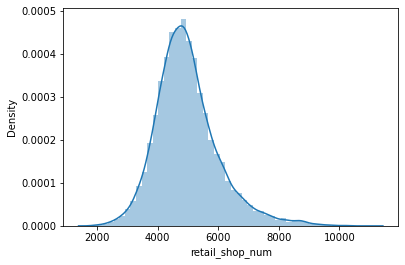

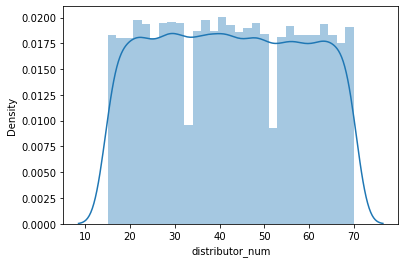

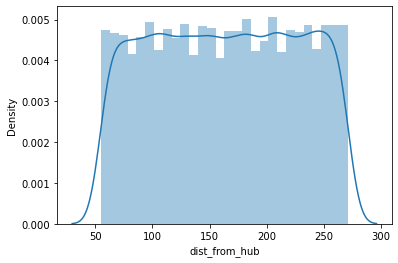

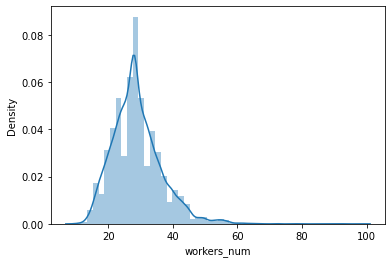

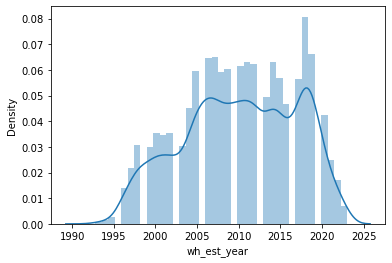

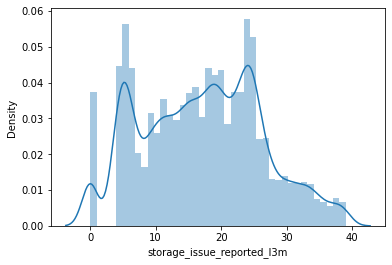

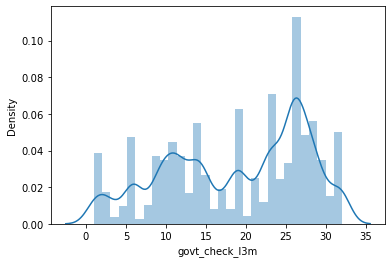

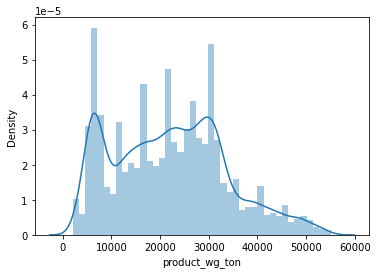

In [38]:
for col in df_numeric.columns:
    plt.figure()
    sns.distplot(df[col])
plt.show()

In [39]:
def custom_summary(my_df):
    result = []
    for col in my_df.columns:
        if my_df[col].dtypes != 'object':
            stats = OrderedDict({
                'Feature Name': col , 
                'Count': my_df[col].count() ,
                'Minimum': my_df[col].min() ,
                'Quartile1': my_df[col].quantile(.25) ,
                'Quartile2': my_df[col].quantile(.50) ,
                'Mean': my_df[col].mean() ,
                'Quartile 3': my_df[col].quantile(.75) ,
                'Maximum': my_df[col].max() ,
                'Variance': round(my_df[col].var()) ,
                'Standard Deviation': my_df[col].std() ,
                'Skewness': my_df[col].skew() , 
                'Kurtosis': my_df[col].kurt()
                })
            result.append(stats)
    result_df = pd.DataFrame(result)
    #Skewness type: 
    skewness_label = []
    for i in result_df['Skewness']:
        if i <= -1:
            skewness_label.append('Highly Negatively Skewed')
        elif -1 < i <= -0.5:
            skewness_label.append('Moderately Negatively Skewed')
        elif -0.5 < i < 0:
            skewness_label.append('Fairly Negatively Skewed')
        elif 0 <= i < 0.5:
            skewness_label.append('Fairly Positively Skewed')
        elif 0.5 <= i < 1:
            skewness_label.append('Moderately Positively Skewed')
        elif i >= 1:
            skewness_label.append('Highly Positively Skewed')
    result_df['Skewness Comment'] = skewness_label
    kurtosis_label = []
    for i in result_df['Kurtosis']:
        if i >= 1:
            kurtosis_label.append('Leptokurtic Curve')
        elif i <= -1:
            kurtosis_label.append('Platykurtic Curve')
        else:
            kurtosis_label.append('Mesokurtic Curve')
    result_df['Kurtosis Comment'] = kurtosis_label
    Outliers_label = []
    for col in my_df.columns:
        if my_df[col].dtypes != 'object':
            Q1 = my_df[col].quantile(0.25)
            Q2 = my_df[col].quantile(0.5)
            Q3 = my_df[col].quantile(0.75)
            IQR = Q3 - Q1
            LW = Q1 - 1.5*IQR
            UW = Q3 + 1.5*IQR
            if len(my_df[(my_df[col] < LW) | (my_df[col] > UW)]) > 0:
                Outliers_label.append('Have Outliers')
            else:
                Outliers_label.append('No Outliers')
    result_df['Outlier Comment'] = Outliers_label
    
    return result_df

In [40]:
custom_summary(df)

,Feature Name,Count,Minimum,Quartile1,Quartile2,Mean,Quartile 3,Maximum,Variance,Standard Deviation,Skewness,Kurtosis,Skewness Comment,Kurtosis Comment,Outlier Comment
0,retail_shop_num,22150,1821,4309.25,4859.0,4983.115711,5499.0,11008,1103832,1050.634225,0.905324,1.846915,Moderately Positively Skewed,Leptokurtic Curve,Have Outliers
1,distributor_num,22150,15,29.00,42.0,42.386998,56.0,70,258,16.057730,0.017210,-1.187118,Fairly Positively Skewed,Platykurtic Curve,No Outliers
2,dist_from_hub,22150,55,109.00,164.0,163.613725,218.0,271,3926,62.660709,-0.009042,-1.200679,Fairly Negatively Skewed,Platykurtic Curve,No Outliers
3,workers_num,22150,10,24.00,28.0,28.899323,33.0,98,59,7.688749,1.077243,3.558098,Highly Positively Skewed,Leptokurtic Curve,Have Outliers
4,wh_est_year,22150,1992,2005.00,2010.0,2010.125056,2016.0,2023,46,6.817783,-0.201431,-0.892559,Fairly Negatively Skewed,Mesokurtic Curve,No Outliers
5,storage_issue_reported_l3m,22150,0,10.00,18.0,17.116659,24.0,39,84,9.174193,0.117473,-0.678794,Fairly Positively Skewed,Mesokurtic Curve,No Outliers
6,govt_check_l3m,22150,1,11.00,20.0,18.767765,26.0,32,75,8.644778,-0.357737,-1.061053,Fairly Negatively Skewed,Platykurtic Curve,No Outliers
7,product_wg_ton,22150,2065,12151.00,22099.0,22086.780813,30102.0,55151,135168348,11626.192340,0.336012,-0.497377,Fairly Positively Skewed,Mesokurtic Curve,No Outliers


In [41]:
chi2test_summary(df)

,Feature Name,P_Value,Chi2_Value,Dof_value,Acceptance Comment,Correlation Comment
0,Location_type,3.587164e-03,4739.680993,4481,Alternate Hypothesis Accepted,Variables are dependent
1,WH_capacity_size,1.085324e-01,9127.601736,8962,Null Hypothesis Accepted,Variables are Independent
2,zone,7.412437e-02,13680.780068,13443,Null Hypothesis Accepted,Variables are Independent
3,WH_regional_zone,7.040504e-01,22291.046172,22405,Null Hypothesis Accepted,Variables are Independent
4,num_refill_req_l3m,4.753149e-01,35863.914385,35848,Null Hypothesis Accepted,Variables are Independent
5,transport_issue_l1y,1.000000e+00,20337.925924,22405,Null Hypothesis Accepted,Variables are Independent
6,Competitor_in_mkt,1.000000e+00,47368.257231,49291,Null Hypothesis Accepted,Variables are Independent
7,wh_owner_type,8.570908e-01,4380.057396,4481,Null Hypothesis Accepted,Variables are Independent
8,flood_impacted,3.095114e-01,4527.566482,4481,Null Hypothesis Accepted,Variables are Independent
9,flood_proof,3.211916e-02,4657.793411,4481,Alternate Hypothesis Accepted,Variables are dependent


### Analysis from the barplot

    1. Three features (transport_issue_l1y,approved_wh_govt_certificate,and wh_breakdown_l3m) have linear correlation with the target variable
    2 The remaining features do not have any significant correlation with the target feature and should be dropped 

# Feature Engineering 

In [42]:
#Creating a new feature wh_age from existing wh_est_year feature
result=[]
for i in df['wh_est_year'].values:
    age = 2022-i 
    result.append(age)
df['wh_age'] = pd.DataFrame(result)
df    

,Location_type,WH_capacity_size,zone,WH_regional_zone,num_refill_req_l3m,transport_issue_l1y,Competitor_in_mkt,retail_shop_num,wh_owner_type,distributor_num,...,dist_from_hub,workers_num,wh_est_year,storage_issue_reported_l3m,temp_reg_mach,approved_wh_govt_certificate,wh_breakdown_l3m,govt_check_l3m,product_wg_ton,wh_age
0,Urban,Small,West,Zone 6,3,1,2,4651,Rented,24,...,91,29,2012,13,0,A,5,15,17115,10
1,Rural,Large,North,Zone 5,0,0,4,6217,Company Owned,47,...,210,31,2019,4,0,A,3,17,5074,3
2,Rural,Mid,South,Zone 2,1,0,4,4306,Company Owned,64,...,161,37,2009,17,0,A,6,22,23137,13
3,Rural,Mid,North,Zone 3,7,4,2,6000,Rented,50,...,103,21,2010,17,1,A+,3,27,22115,12
4,Rural,Large,North,Zone 5,3,1,2,4740,Company Owned,42,...,112,25,2009,18,0,C,6,24,24071,13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22145,Rural,Large,North,Zone 6,8,1,3,5030,Rented,46,...,203,28,2007,22,1,A+,2,4,29138,15
22146,Rural,Small,South,Zone 6,3,1,3,4320,Rented,60,...,170,28,2004,26,0,C,5,9,33108,18
22147,Rural,Large,North,Zone 6,7,2,2,5268,Company Owned,64,...,99,22,2009,20,0,B+,6,4,24072,13
22148,Rural,Large,North,Zone 6,6,2,4,4378,Rented,32,...,220,17,2014,13,0,B,3,28,15055,8


In [43]:
#Conducting anova test on the newly created numerical feature - wh_age
model = ols('product_wg_ton ~ C(wh_age)', data=df).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
anova_table

,sum_sq,df,F,PR(>F)
C(wh_age),2.460261e+12,31.0,3289.756753,0.0
Residual,5.335825e+11,22118.0,NaN,NaN


Text(0.5, 1.0, 'Relationship Between wh_age and product_wg_ton')

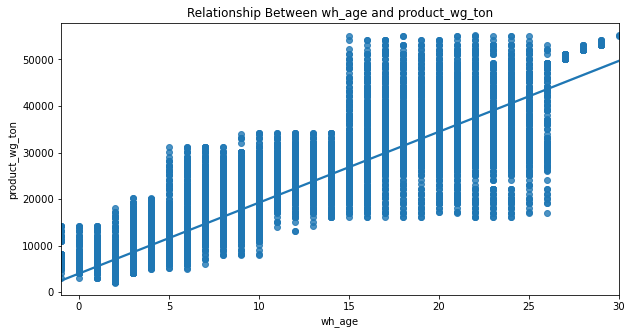

In [44]:
fig , ax1 = plt.subplots(figsize = (10,5))
sns.regplot(x = df['wh_age'] , y = df['product_wg_ton'] , ax = ax1).set_title(f'Relationship Between wh_age and product_wg_ton')
                                            

In [45]:
df1= df['Location_type']
df2= df['zone']
df['location_zone'] = df1.add(df2)
df

,Location_type,WH_capacity_size,zone,WH_regional_zone,num_refill_req_l3m,transport_issue_l1y,Competitor_in_mkt,retail_shop_num,wh_owner_type,distributor_num,...,workers_num,wh_est_year,storage_issue_reported_l3m,temp_reg_mach,approved_wh_govt_certificate,wh_breakdown_l3m,govt_check_l3m,product_wg_ton,wh_age,location_zone
0,Urban,Small,West,Zone 6,3,1,2,4651,Rented,24,...,29,2012,13,0,A,5,15,17115,10,UrbanWest
1,Rural,Large,North,Zone 5,0,0,4,6217,Company Owned,47,...,31,2019,4,0,A,3,17,5074,3,RuralNorth
2,Rural,Mid,South,Zone 2,1,0,4,4306,Company Owned,64,...,37,2009,17,0,A,6,22,23137,13,RuralSouth
3,Rural,Mid,North,Zone 3,7,4,2,6000,Rented,50,...,21,2010,17,1,A+,3,27,22115,12,RuralNorth
4,Rural,Large,North,Zone 5,3,1,2,4740,Company Owned,42,...,25,2009,18,0,C,6,24,24071,13,RuralNorth
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22145,Rural,Large,North,Zone 6,8,1,3,5030,Rented,46,...,28,2007,22,1,A+,2,4,29138,15,RuralNorth
22146,Rural,Small,South,Zone 6,3,1,3,4320,Rented,60,...,28,2004,26,0,C,5,9,33108,18,RuralSouth
22147,Rural,Large,North,Zone 6,7,2,2,5268,Company Owned,64,...,22,2009,20,0,B+,6,4,24072,13,RuralNorth
22148,Rural,Large,North,Zone 6,6,2,4,4378,Rented,32,...,17,2014,13,0,B,3,28,15055,8,RuralNorth


In [46]:
#Conducting Ch12 test on the newly created categorical feature - location_Zone
contigency= pd.crosstab(df['location_zone'],df['product_wg_ton']) 
c, p, dof, expected = chi2_contingency(contigency)
print(p)

0.0010346294334821495


<AxesSubplot:xlabel='location_zone', ylabel='product_wg_ton'>

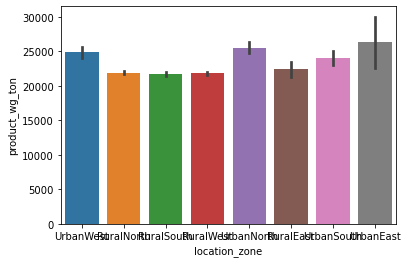

In [47]:
sns.barplot(x='location_zone', y="product_wg_ton",data = df,estimator = mean)

### Analysis of the newly created features

    1. wh_age and location_zone have correlation  with the target feature by considering their p_values and the graphs

# Feature Selection - Numerical Features 

## Multicolinearity Test - Correlation Matrix

<AxesSubplot:>

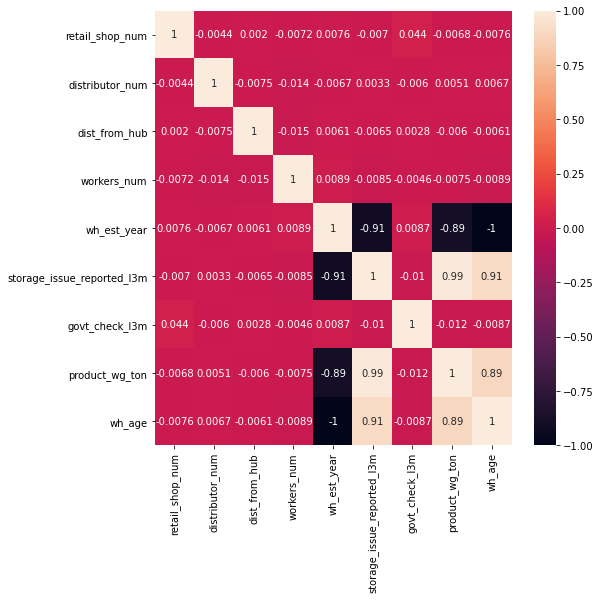

In [48]:
corr= df.corr()
df.ax = plt.subplots(figsize = (8,8))
sns.heatmap(corr, annot = True)

## Multicollinearity Test - VIF Method
- Variance inflation Factor(VIF)
Formula for VIF is = 1 / (1-R2)

steps:
1. Regress every indepedent variable with each other and calculate the R2
2. Find VIF using above formula.
3. If VIF is more than 10 , we say that multicollinearity exists.


In [49]:
df_numeric = df.select_dtypes(include=['float64', 'int64'])

In [50]:
df_numeric.head()

,retail_shop_num,distributor_num,dist_from_hub,workers_num,wh_est_year,storage_issue_reported_l3m,govt_check_l3m,product_wg_ton,wh_age
0,4651,24,91,29,2012,13,15,17115,10
1,6217,47,210,31,2019,4,17,5074,3
2,4306,64,161,37,2009,17,22,23137,13
3,6000,50,103,21,2010,17,27,22115,12
4,4740,42,112,25,2009,18,24,24071,13


In [51]:

num = df_numeric.drop('product_wg_ton', axis = 1)
num

,retail_shop_num,distributor_num,dist_from_hub,workers_num,wh_est_year,storage_issue_reported_l3m,govt_check_l3m,wh_age
0,4651,24,91,29,2012,13,15,10
1,6217,47,210,31,2019,4,17,3
2,4306,64,161,37,2009,17,22,13
3,6000,50,103,21,2010,17,27,12
4,4740,42,112,25,2009,18,24,13
...,...,...,...,...,...,...,...,...
22145,5030,46,203,28,2007,22,4,15
22146,4320,60,170,28,2004,26,9,18
22147,5268,64,99,22,2009,20,4,13
22148,4378,32,220,17,2014,13,28,8


In [52]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
vif = pd.DataFrame()
vif["features"] = num.columns
vif["vif_Factor"] = [variance_inflation_factor(num.values, i) for i in range(num.shape[1])]
vif

,features,vif_Factor
0,retail_shop_num,1.002024
1,distributor_num,1.000398
2,dist_from_hub,1.000334
3,workers_num,1.000574
4,wh_est_year,59.549637
5,storage_issue_reported_l3m,5.683053
6,govt_check_l3m,1.002064
7,wh_age,22.920388


### Analysis from VIF result
    1. Two features(wh_est_year and wh_age) have VIF score more than 10 so we can conclude that multicollinearity exist in this data.
    2. Since the two features are correlated and equally have strong correlation with the target variables, one of them can be dropped



# Feature Selection - Categorical Features 

In [53]:
df_char = df.select_dtypes(include=['object'])

In [54]:
df_char.dtypes

Location_type                   object
WH_capacity_size                object
zone                            object
WH_regional_zone                object
num_refill_req_l3m              object
transport_issue_l1y             object
Competitor_in_mkt               object
wh_owner_type                   object
flood_impacted                  object
flood_proof                     object
electric_supply                 object
temp_reg_mach                   object
approved_wh_govt_certificate    object
wh_breakdown_l3m                object
location_zone                   object
dtype: object

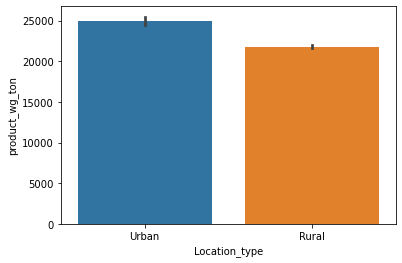

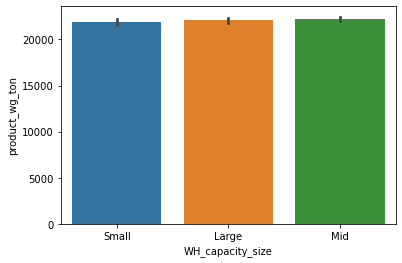

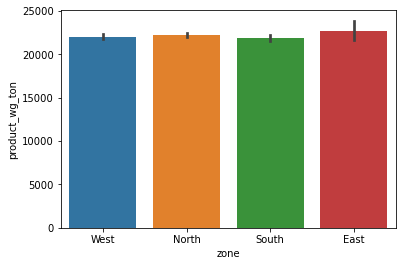

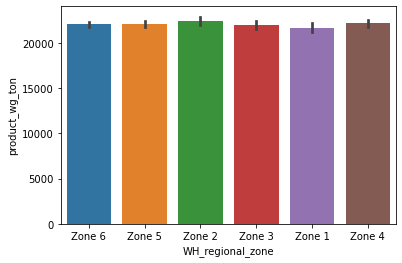

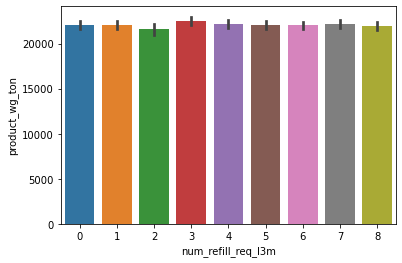

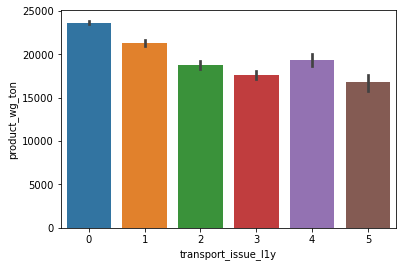

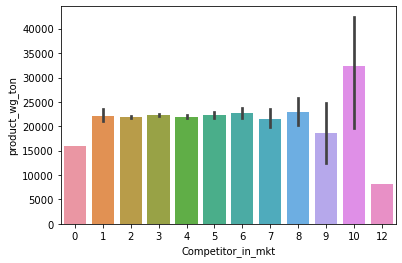

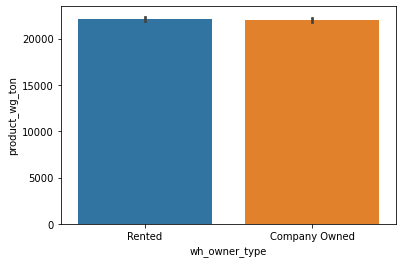

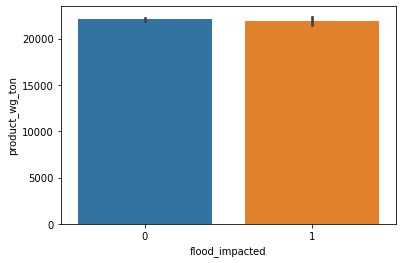

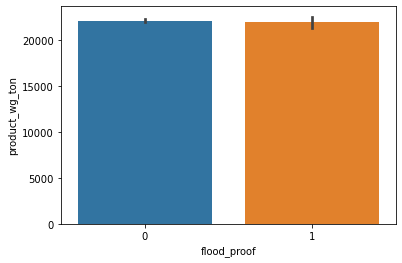

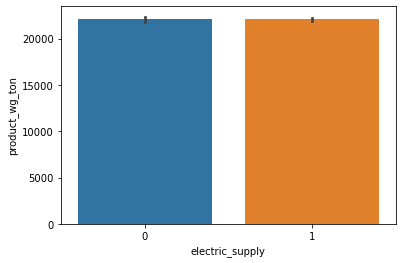

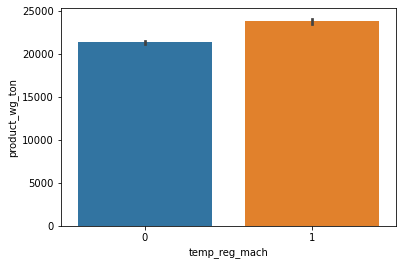

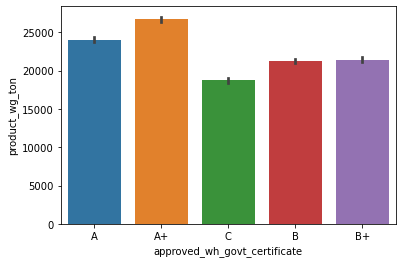

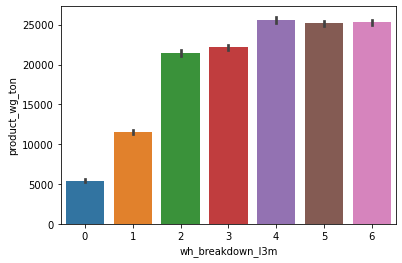

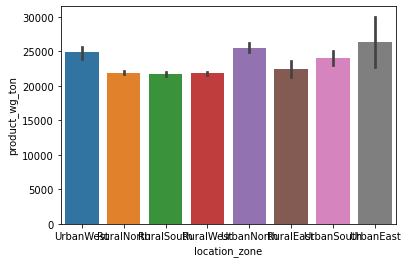

In [55]:
from numpy import mean

for col in df_char.columns:
    plt.figure()
    sns.barplot(x=col, y="product_wg_ton",data = df,estimator = mean)
plt.show()

### Analysis from the barplot

    1. Four features (transport_issue_l1y,approved_wh_govt_certificate,wh_breakdown_l3m, and location_zone) have linear correlation with the target variable
    2 The remaining features do not have any significant correlation with the target feature and should be dropped 

In [56]:
df_char

,Location_type,WH_capacity_size,zone,WH_regional_zone,num_refill_req_l3m,transport_issue_l1y,Competitor_in_mkt,wh_owner_type,flood_impacted,flood_proof,electric_supply,temp_reg_mach,approved_wh_govt_certificate,wh_breakdown_l3m,location_zone
0,Urban,Small,West,Zone 6,3,1,2,Rented,0,1,1,0,A,5,UrbanWest
1,Rural,Large,North,Zone 5,0,0,4,Company Owned,0,0,1,0,A,3,RuralNorth
2,Rural,Mid,South,Zone 2,1,0,4,Company Owned,0,0,0,0,A,6,RuralSouth
3,Rural,Mid,North,Zone 3,7,4,2,Rented,0,0,0,1,A+,3,RuralNorth
4,Rural,Large,North,Zone 5,3,1,2,Company Owned,1,0,1,0,C,6,RuralNorth
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22145,Rural,Large,North,Zone 6,8,1,3,Rented,0,0,1,1,A+,2,RuralNorth
22146,Rural,Small,South,Zone 6,3,1,3,Rented,0,0,0,0,C,5,RuralSouth
22147,Rural,Large,North,Zone 6,7,2,2,Company Owned,0,0,0,0,B+,6,RuralNorth
22148,Rural,Large,North,Zone 6,6,2,4,Rented,0,0,0,0,B,3,RuralNorth


In [57]:
#Label Encoding for object to numeric conversion
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

df_char_with_labels = df_char.apply(le.fit_transform)



In [58]:
df_char_with_labels

,Location_type,WH_capacity_size,zone,WH_regional_zone,num_refill_req_l3m,transport_issue_l1y,Competitor_in_mkt,wh_owner_type,flood_impacted,flood_proof,electric_supply,temp_reg_mach,approved_wh_govt_certificate,wh_breakdown_l3m,location_zone
0,1,2,3,5,3,1,2,1,0,1,1,0,0,5,7
1,0,0,1,4,0,0,4,0,0,0,1,0,0,3,1
2,0,1,2,1,1,0,4,0,0,0,0,0,0,6,2
3,0,1,1,2,7,4,2,1,0,0,0,1,1,3,1
4,0,0,1,4,3,1,2,0,1,0,1,0,4,6,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22145,0,0,1,5,8,1,3,1,0,0,1,1,1,2,1
22146,0,2,2,5,3,1,3,1,0,0,0,0,4,5,2
22147,0,0,1,5,7,2,2,0,0,0,0,0,3,6,1
22148,0,0,1,5,6,2,4,1,0,0,0,0,2,3,1


## Model Building
Stages of Model Building
* Create the master feature set for model development
* Custom train test split function
* Model Evaluation


### Creating the Master Feature Set for Model Development

In [60]:
X= pd.concat([num, df_char_with_labels], axis=1)
df_new = X.join(df['product_wg_ton'], how = 'left')

y = df_new[['product_wg_ton']]

In [61]:
df_new

,retail_shop_num,distributor_num,dist_from_hub,workers_num,wh_est_year,storage_issue_reported_l3m,govt_check_l3m,wh_age,Location_type,WH_capacity_size,...,Competitor_in_mkt,wh_owner_type,flood_impacted,flood_proof,electric_supply,temp_reg_mach,approved_wh_govt_certificate,wh_breakdown_l3m,location_zone,product_wg_ton
0,4651,24,91,29,2012,13,15,10,1,2,...,2,1,0,1,1,0,0,5,7,17115
1,6217,47,210,31,2019,4,17,3,0,0,...,4,0,0,0,1,0,0,3,1,5074
2,4306,64,161,37,2009,17,22,13,0,1,...,4,0,0,0,0,0,0,6,2,23137
3,6000,50,103,21,2010,17,27,12,0,1,...,2,1,0,0,0,1,1,3,1,22115
4,4740,42,112,25,2009,18,24,13,0,0,...,2,0,1,0,1,0,4,6,1,24071
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22145,5030,46,203,28,2007,22,4,15,0,0,...,3,1,0,0,1,1,1,2,1,29138
22146,4320,60,170,28,2004,26,9,18,0,2,...,3,1,0,0,0,0,4,5,2,33108
22147,5268,64,99,22,2009,20,4,13,0,0,...,2,0,0,0,0,0,3,6,1,24072
22148,4378,32,220,17,2014,13,28,8,0,0,...,4,1,0,0,0,0,2,3,1,15055


### Train Test Split

In [62]:
def train_and_test_split(data, tcol, testSize = 0.3, randomState = 3):
    X = data.drop(tcol, axis = 1)
    y = data[tcol]
    return train_test_split(X,y,test_size = testSize, random_state = randomState)

In [63]:
def model_builder(model_name, model, data, t_col):
    X_train, X_test, y_train, y_test = train_and_test_split(data, t_col)
    model.fit(X_train,y_train)
    y_pred = model.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    result = [model_name , rmse, r2]
    return result

In [64]:
model_builder(model_name = 'Ridge' , model = XGBRegressor(), data = df_new, t_col = 'product_wg_ton')

['Ridge', 862.0360848298906, 0.9945469441507473]

In [65]:
def multiple_models(data,t_col):
    col_names = ["Model Name","RMSE","R2 Score"]
    result = pd.DataFrame(columns = col_names)
    result.loc[len(result)] = model_builder("Linear Regression",LinearRegression(),data,t_col) # Calling mode_builder function and it is already know to that
    result.loc[len(result)] = model_builder("Lasso Regression",Lasso(),data,t_col)   
    result.loc[len(result)] = model_builder("Ridge Regression",Ridge(),data,t_col)
    result.loc[len(result)] = model_builder("DTR",DecisionTreeRegressor(),data,t_col)
    result.loc[len(result)] = model_builder("SVR",SVR(),data,t_col)
    result.loc[len(result)] = model_builder("KNN",KNeighborsRegressor(),data,t_col)
    result.loc[len(result)] = model_builder("Random Forest Regressor",RandomForestRegressor(),data,t_col)
    result.loc[len(result)] = model_builder("Ada Boost Regressor",AdaBoostRegressor(),data,t_col)
    result.loc[len(result)] = model_builder("Gradient Boosting Regressor",GradientBoostingRegressor(),data,t_col)
    result.loc[len(result)] = model_builder("xg Boosting Regressor",XGBRegressor(),data,t_col)
    #return result.sort_values("RMSE",ascending = False)
    return result.sort_values("R2 Score",ascending = False)

In [66]:
multiple_models(df_new,"product_wg_ton")

,Model Name,RMSE,R2 Score
6,Random Forest Regressor,859.552119,0.994578
9,xg Boosting Regressor,862.036085,0.994547
8,Gradient Boosting Regressor,907.292191,0.993959
3,DTR,1170.558713,0.989945
7,Ada Boost Regressor,1749.753501,0.977533
1,Lasso Regression,1789.941584,0.976489
0,Linear Regression,1790.061220,0.976486
2,Ridge Regression,1790.061267,0.976486
5,KNN,6513.732703,0.688650
4,SVR,11674.509309,-0.000153


### Post Model Evaluation - Cross Validation

In [68]:
def k_fold_cv(X,y,fold=10):
    score_lr = cross_val_score(LinearRegression(),X,y,cv = fold)
    score_ls = cross_val_score(Lasso(),X,y,cv = fold)
    score_rd = cross_val_score(Ridge(),X,y,cv = fold)
    score_dtr = cross_val_score(DecisionTreeRegressor(),X,y,cv = fold)
    score_svr = cross_val_score(SVR(),X,y,cv = fold)
    score_knn = cross_val_score(KNeighborsRegressor(),X,y,cv = fold)
    score_rf = cross_val_score(RandomForestRegressor(),X,y,cv = fold)
    score_ab = cross_val_score(AdaBoostRegressor(),X,y,cv = fold)
    score_gb = cross_val_score(GradientBoostingRegressor(),X,y,cv = fold)
    score_xb = cross_val_score(XGBRegressor(),X,y,cv = fold)
    
    model_name = ["Linear Regression","Lasso","Ridge","DTR","SVR","KNN","Random Forest Regressor",
                  "Ada Boost Regressor","Gradient Boosting Regressor","xg Boosting Regressor"]
    scores = [score_lr,score_ls,score_rd,score_dtr,score_svr,score_knn,
             score_rf,score_ab,score_gb,score_xb]
    result = []
    for i in range(len(model_name)):
        score_mean = np.mean(scores[i])
        score_std = np.std(scores[i])
        m_name = model_name[i]
        tmp = [m_name,score_mean,score_std]
        result.append(tmp)
    k_fold_df = pd.DataFrame(result,columns = ["Model Name","CV Accuracy","CV Standard Deviation"])
    return k_fold_df.sort_values("CV Accuracy",ascending =  False)
    
    

In [69]:
k_fold_cv(df_new.drop("product_wg_ton",axis = 1),df_new["product_wg_ton"])

,Model Name,CV Accuracy,CV Standard Deviation
6,Random Forest Regressor,0.995045,0.000397
9,xg Boosting Regressor,0.994857,0.000371
8,Gradient Boosting Regressor,0.994201,0.000433
3,DTR,0.990921,0.000704
7,Ada Boost Regressor,0.977556,0.001044
1,Lasso,0.977126,0.001327
2,Ridge,0.977126,0.001327
0,Linear Regression,0.977126,0.001327
5,KNN,0.711059,0.008272
4,SVR,-0.000370,0.000427


## Understanding Feature Importance using Random Forest, XGBoost, Gradient Boost, Lineer Regression and Ridge 

In [90]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.3, random_state=1)

In [91]:
xgb = XGBRegressor()
xgb.fit(X_train , y_train)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
             grow_policy='depthwise', importance_type=None,
             interaction_constraints='', learning_rate=0.300000012, max_bin=256,
             max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
             max_depth=6, max_leaves=0, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, ...)

In [92]:
y_train_pred=xgb.predict(X_train)
DF_y_train_pred=pd.DataFrame(y_train_pred,columns=['product_wg_ton_predict'])
X_train.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)
DF_y_train_pred.reset_index(drop=True, inplace=True)

Train_with_pred=pd.concat([X_train,y_train,DF_y_train_pred], axis=1)
Train_with_pred

,retail_shop_num,distributor_num,dist_from_hub,workers_num,wh_est_year,storage_issue_reported_l3m,govt_check_l3m,wh_age,Location_type,WH_capacity_size,...,wh_owner_type,flood_impacted,flood_proof,electric_supply,temp_reg_mach,approved_wh_govt_certificate,wh_breakdown_l3m,location_zone,product_wg_ton,product_wg_ton_predict
0,4413,49,162,29,2002,27,10,20,0,0,...,0,0,0,1,0,3,4,2,33056,32487.816406
1,4727,64,137,36,2001,28,27,21,1,1,...,0,0,0,0,0,2,5,5,33081,33821.457031
2,4981,67,173,39,2003,36,6,19,0,0,...,0,0,0,1,0,2,5,1,45143,45360.656250
3,4178,42,239,42,2005,26,11,17,1,1,...,1,0,0,1,0,3,4,6,31143,30413.683594
4,4986,29,116,29,2006,15,18,16,0,1,...,0,0,0,1,0,2,3,3,19064,18549.472656
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15500,5480,23,167,21,2014,12,11,8,0,1,...,0,0,0,1,0,2,3,3,15132,14531.833984
15501,5152,54,110,33,2008,19,27,14,0,1,...,0,0,0,1,1,1,4,2,25059,24798.011719
15502,4196,68,107,28,2018,6,19,4,0,1,...,0,0,0,1,0,4,1,2,8143,7577.180176
15503,3227,57,159,22,2002,25,27,20,0,1,...,0,0,0,1,1,1,2,2,32120,32231.914062


In [93]:
y_test_pred=xgb.predict(X_test)
DF_y_test_pred=pd.DataFrame(y_test_pred,columns=['product_wg_ton_predict'])
X_test.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)
DF_y_test_pred.reset_index(drop=True, inplace=True)

Test_with_pred=pd.concat([X_test,y_test,DF_y_test_pred], axis=1)
Test_with_pred

,retail_shop_num,distributor_num,dist_from_hub,workers_num,wh_est_year,storage_issue_reported_l3m,govt_check_l3m,wh_age,Location_type,WH_capacity_size,...,wh_owner_type,flood_impacted,flood_proof,electric_supply,temp_reg_mach,approved_wh_govt_certificate,wh_breakdown_l3m,location_zone,product_wg_ton,product_wg_ton_predict
0,3801,17,55,24,2000,25,23,22,0,0,...,0,0,0,0,0,0,4,1,32146,32739.115234
1,4746,47,73,27,2019,4,2,3,0,2,...,0,0,0,1,0,3,3,3,5124,5026.509277
2,5043,46,163,40,2021,5,25,1,0,0,...,0,0,0,1,1,2,2,3,6055,6733.023438
3,5121,28,209,23,2002,23,17,20,0,0,...,1,0,0,1,0,0,4,1,32115,30261.697266
4,5416,28,87,20,2010,17,14,12,0,0,...,1,0,0,0,0,4,5,1,22070,22197.369141
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6640,6719,24,270,39,2020,5,32,2,0,1,...,0,0,0,1,1,3,2,2,6137,6427.829590
6641,4225,15,226,33,1995,37,29,27,0,0,...,1,0,0,0,0,0,5,2,50100,50261.523438
6642,5259,50,212,29,1996,22,28,26,0,0,...,0,1,1,1,0,4,4,1,30085,28378.216797
6643,6537,57,142,29,2018,5,23,4,0,0,...,0,0,0,1,0,3,5,3,6093,6111.625000


In [74]:
model = LinearRegression()
model.fit(X_train,y_train)
importances = pd.DataFrame(data={
    'Attribute': X_train.columns,
    'Importance': model.coef_[0]
})
importances = importances.sort_values(by='Importance', ascending=False)

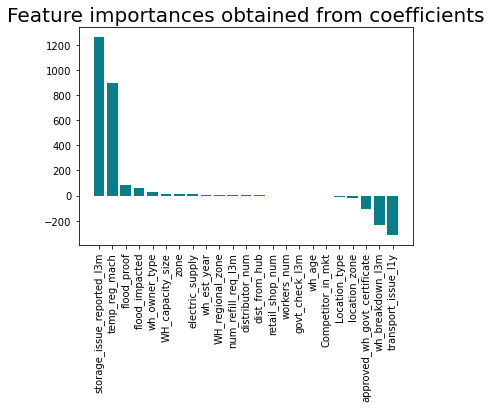

In [75]:
plt.bar(x=importances['Attribute'], height=importances['Importance'], color='#087E8B')
plt.title('Feature importances obtained from coefficients', size=20)
plt.xticks(rotation='vertical')
plt.show()

In [76]:
model = Ridge()
model.fit(X_train,y_train)
importances = pd.DataFrame(data={
    'Attribute': X_train.columns,
    'Importance': model.coef_[0]
})
importances = importances.sort_values(by='Importance', ascending=False)

<function matplotlib.pyplot.show(close=None, block=None)>

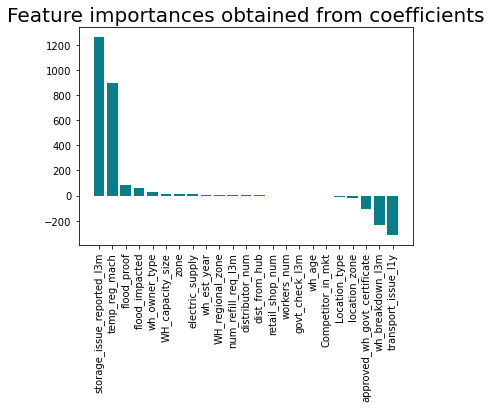

In [77]:
plt.bar(x=importances['Attribute'], height=importances['Importance'], color='#087E8B')
plt.title('Feature importances obtained from coefficients', size=20)
plt.xticks(rotation='vertical')
plt.show

In [78]:
rf = RandomForestRegressor(n_estimators=100)
rf.fit(X_train , y_train)

RandomForestRegressor()

In [79]:
rf.feature_importances_

array([6.23102512e-04, 5.35451791e-04, 5.71847735e-04, 4.59505138e-04,
       1.23781928e-03, 9.82903150e-01, 4.26600267e-04, 1.23241010e-03,
       1.57104638e-05, 9.19943475e-05, 9.06992805e-05, 1.72789200e-04,
       4.56752119e-04, 6.37991679e-04, 2.07892699e-04, 8.92758092e-05,
       6.89356292e-05, 3.07879767e-05, 6.18490996e-05, 6.61647525e-04,
       8.90936207e-03, 3.94119007e-04, 1.20306310e-04])

In [80]:
X.columns

Index(['retail_shop_num', 'distributor_num', 'dist_from_hub', 'workers_num',
       'wh_est_year', 'storage_issue_reported_l3m', 'govt_check_l3m', 'wh_age',
       'Location_type', 'WH_capacity_size', 'zone', 'WH_regional_zone',
       'num_refill_req_l3m', 'transport_issue_l1y', 'Competitor_in_mkt',
       'wh_owner_type', 'flood_impacted', 'flood_proof', 'electric_supply',
       'temp_reg_mach', 'approved_wh_govt_certificate', 'wh_breakdown_l3m',
       'location_zone'],
      dtype='object')

In [81]:
gb = GradientBoostingRegressor()
gb.fit(X_train , y_train)

GradientBoostingRegressor()

In [189]:
def plot_feature_importance(importance,names,model_type):

    #Create arrays from feature importance and feature names
    feature_importance = np.array(importance)
    feature_names = np.array(names)

    #Create a DataFrame using a Dictionary
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)

    #Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)

    #Define size of bar plot
    plt.figure(figsize=(10,8))
    #Plot Searborn bar chart
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
    #Add chart labels
    plt.title(model_type + ' ' + 'FEATURE IMPORTANCE')
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')
    

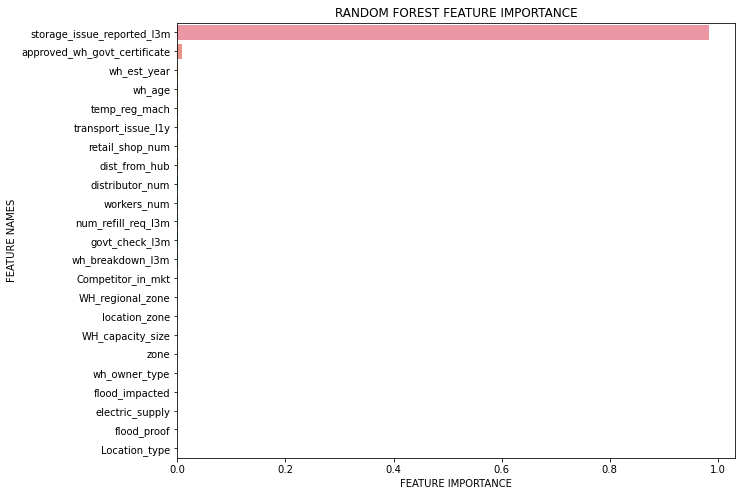

In [190]:
plot_feature_importance(rf.feature_importances_,X_train.columns,'RANDOM FOREST')

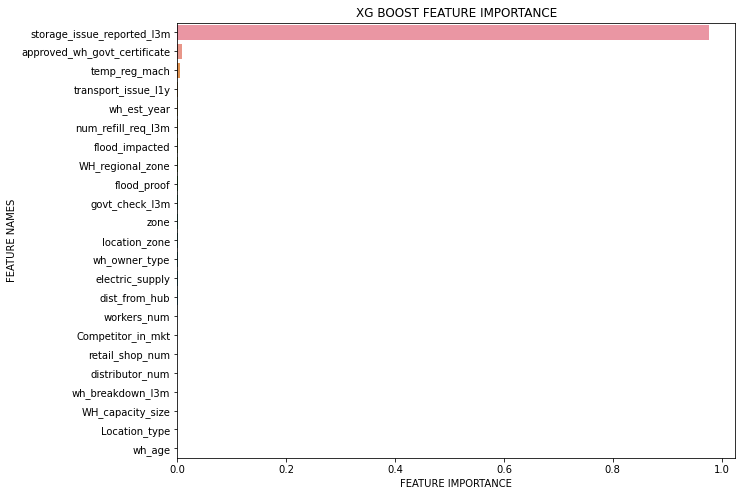

In [191]:
plot_feature_importance(xgb.feature_importances_,X_train.columns,'XG BOOST')

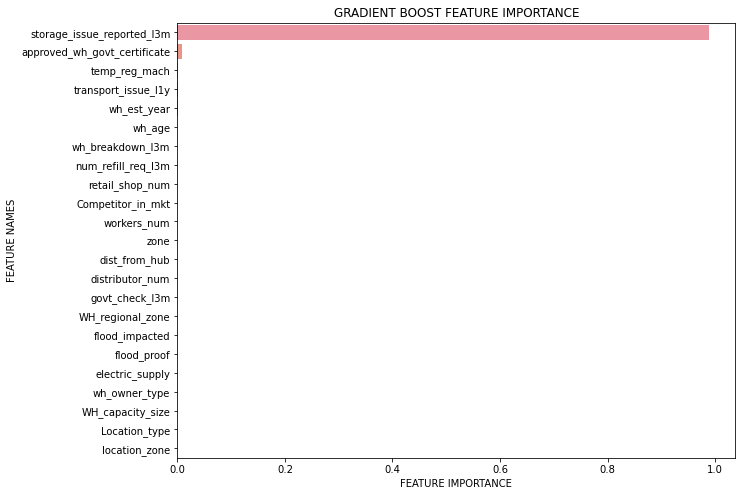

In [192]:
plot_feature_importance(gb.feature_importances_,X_train.columns,'GRADIENT BOOST')


In [86]:
X_train=sm.add_constant(X_train)
model_object=sm.OLS(y_train,X_train)
model=model_object.fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:         product_wg_ton   R-squared:                       0.977
Model:                            OLS   Adj. R-squared:                  0.977
Method:                 Least Squares   F-statistic:                 3.159e+04
Date:                Sat, 24 Dec 2022   Prob (F-statistic):               0.00
Time:                        11:27:27   Log-Likelihood:            -1.3786e+05
No. Observations:               15505   AIC:                         2.758e+05
Df Residuals:                   15483   BIC:                         2.759e+05
Df Model:                          21                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const           

## Preprocessing the Test dataset

In [88]:
df2= pd.read_excel('supply chain test dataset.xlsx')
df2.head()

,Ware_house_ID,WH_Manager_ID,Location_type,WH_capacity_size,zone,WH_regional_zone,num_refill_req_l3m,transport_issue_l1y,Competitor_in_mkt,retail_shop_num,...,flood_proof,electric_supply,dist_from_hub,workers_num,wh_est_year,storage_issue_reported_l3m,temp_reg_mach,approved_wh_govt_certificate,wh_breakdown_l3m,govt_check_l3m
0,WH_122250,EID_72250,Rural,Large,North,Zone 6,7,0,2,5397,...,0,1,75,30.0,2019.0,9,1,A,1,29
1,WH_122251,EID_72251,Rural,Large,North,Zone 6,8,2,2,5183,...,0,0,138,20.0,2006.0,25,0,A,4,23
2,WH_122252,EID_72252,Rural,Large,North,Zone 6,3,0,4,4665,...,0,1,188,34.0,NaN,24,0,B,4,23
3,WH_122253,EID_72253,Rural,Mid,North,Zone 2,2,0,3,5196,...,0,1,156,31.0,NaN,15,0,A,4,1
4,WH_122254,EID_72254,Rural,Mid,North,Zone 2,5,2,4,8275,...,0,1,237,NaN,NaN,21,1,B+,2,12


In [94]:
df2.shape

(2750, 23)

In [97]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2750 entries, 0 to 2749
Data columns (total 23 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Ware_house_ID                 2750 non-null   object 
 1   WH_Manager_ID                 2750 non-null   object 
 2   Location_type                 2750 non-null   object 
 3   WH_capacity_size              2750 non-null   object 
 4   zone                          2750 non-null   object 
 5   WH_regional_zone              2750 non-null   object 
 6   num_refill_req_l3m            2750 non-null   int64  
 7   transport_issue_l1y           2750 non-null   int64  
 8   Competitor_in_mkt             2750 non-null   int64  
 9   retail_shop_num               2750 non-null   int64  
 10  wh_owner_type                 2750 non-null   object 
 11  distributor_num               2750 non-null   int64  
 12  flood_impacted                2750 non-null   int64  
 13  flo

In [98]:
df2.isnull().sum()

Ware_house_ID                      0
WH_Manager_ID                      0
Location_type                      0
WH_capacity_size                   0
zone                               0
WH_regional_zone                   0
num_refill_req_l3m                 0
transport_issue_l1y                0
Competitor_in_mkt                  0
retail_shop_num                    0
wh_owner_type                      0
distributor_num                    0
flood_impacted                     0
flood_proof                        0
electric_supply                    0
dist_from_hub                      0
workers_num                      110
wh_est_year                     1288
storage_issue_reported_l3m         0
temp_reg_mach                      0
approved_wh_govt_certificate     101
wh_breakdown_l3m                   0
govt_check_l3m                     0
dtype: int64

In [99]:
df2.describe()

,num_refill_req_l3m,transport_issue_l1y,Competitor_in_mkt,retail_shop_num,distributor_num,flood_impacted,flood_proof,electric_supply,dist_from_hub,workers_num,wh_est_year,storage_issue_reported_l3m,temp_reg_mach,wh_breakdown_l3m,govt_check_l3m
count,2750.000000,2750.000000,2750.000000,2750.000000,2750.000000,2750.000000,2750.000000,2750.000000,2750.000000,2640.000000,1462.000000,2750.000000,2750.000000,2750.000000,2750.000000
mean,4.030182,0.745818,3.114909,5011.705818,42.655636,0.096000,0.056000,0.662545,163.157818,29.007197,2009.223666,17.217455,0.293818,3.431273,19.106545
std,2.610002,1.183942,1.134737,1066.379543,16.133231,0.294645,0.229964,0.472927,63.162420,8.057788,7.545158,9.050844,0.455593,1.678671,8.547936
min,0.000000,0.000000,1.000000,2018.000000,15.000000,0.000000,0.000000,0.000000,55.000000,11.000000,1996.000000,0.000000,0.000000,0.000000,1.000000
25%,2.000000,0.000000,2.000000,4341.250000,29.000000,0.000000,0.000000,0.000000,109.000000,24.000000,2003.000000,10.000000,0.000000,2.000000,12.000000
50%,4.000000,0.000000,3.000000,4871.000000,43.000000,0.000000,0.000000,1.000000,164.000000,28.000000,2009.000000,18.000000,0.000000,3.000000,21.000000
75%,6.000000,1.000000,4.000000,5504.000000,57.000000,0.000000,0.000000,1.000000,217.000000,33.000000,2015.000000,24.000000,1.000000,5.000000,26.000000
max,8.000000,5.000000,9.000000,10562.000000,70.000000,1.000000,1.000000,1.000000,271.000000,92.000000,2023.000000,39.000000,1.000000,6.000000,32.000000


In [156]:
df2 = pd.read_excel('supply chain test dataset.xlsx')
cols = ['storage_issue_reported_l3m','retail_shop_num','workers_num','wh_est_year']
x = df2[cols]
x

,storage_issue_reported_l3m,retail_shop_num,workers_num,wh_est_year
0,9,5397,30.0,2019.0
1,25,5183,20.0,2006.0
2,24,4665,34.0,NaN
3,15,5196,31.0,NaN
4,21,8275,NaN,NaN
...,...,...,...,...
2745,22,5390,34.0,2005.0
2746,10,4490,28.0,2012.0
2747,23,5403,NaN,NaN
2748,18,10562,25.0,NaN


In [157]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

impute_it = IterativeImputer()
df3 = impute_it.fit_transform(x)
df3

array([[9.00000000e+00, 5.39700000e+03, 3.00000000e+01, 2.01900000e+03],
       [2.50000000e+01, 5.18300000e+03, 2.00000000e+01, 2.00600000e+03],
       [2.40000000e+01, 4.66500000e+03, 3.40000000e+01, 2.00534915e+03],
       ...,
       [2.30000000e+01, 5.40300000e+03, 2.90146270e+01, 2.00605713e+03],
       [1.80000000e+01, 1.05620000e+04, 2.50000000e+01, 2.00984413e+03],
       [4.00000000e+00, 5.66400000e+03, 3.90000000e+01, 2.01900000e+03]])

In [159]:
df3 = pd.DataFrame(df3, columns = ['storage_issue_reported_l3m','retail_shop_num','workers_num','year'])
df3

,storage_issue_reported_l3m,retail_shop_num,workers_num,year
0,9.0,5397.0,30.000000,2019.000000
1,25.0,5183.0,20.000000,2006.000000
2,24.0,4665.0,34.000000,2005.349147
3,15.0,5196.0,31.000000,2011.655733
4,21.0,8275.0,29.078770,2007.634413
...,...,...,...,...
2745,22.0,5390.0,34.000000,2005.000000
2746,10.0,4490.0,28.000000,2012.000000
2747,23.0,5403.0,29.014627,2006.057130
2748,18.0,10562.0,25.000000,2009.844132


In [160]:
df2['wh_est_year'] = df3['year']
df2['wh_est_year'] = df2['wh_est_year'].astype('int64')
df2

,Ware_house_ID,WH_Manager_ID,Location_type,WH_capacity_size,zone,WH_regional_zone,num_refill_req_l3m,transport_issue_l1y,Competitor_in_mkt,retail_shop_num,...,flood_proof,electric_supply,dist_from_hub,workers_num,wh_est_year,storage_issue_reported_l3m,temp_reg_mach,approved_wh_govt_certificate,wh_breakdown_l3m,govt_check_l3m
0,WH_122250,EID_72250,Rural,Large,North,Zone 6,7,0,2,5397,...,0,1,75,30.0,2019,9,1,A,1,29
1,WH_122251,EID_72251,Rural,Large,North,Zone 6,8,2,2,5183,...,0,0,138,20.0,2006,25,0,A,4,23
2,WH_122252,EID_72252,Rural,Large,North,Zone 6,3,0,4,4665,...,0,1,188,34.0,2005,24,0,B,4,23
3,WH_122253,EID_72253,Rural,Mid,North,Zone 2,2,0,3,5196,...,0,1,156,31.0,2011,15,0,A,4,1
4,WH_122254,EID_72254,Rural,Mid,North,Zone 2,5,2,4,8275,...,0,1,237,NaN,2007,21,1,B+,2,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2745,WH_124995,EID_74995,Rural,Small,North,Zone 1,3,0,4,5390,...,0,1,142,34.0,2005,22,1,A,2,30
2746,WH_124996,EID_74996,Rural,Mid,West,Zone 2,6,0,4,4490,...,0,1,130,28.0,2012,10,0,B,4,18
2747,WH_124997,EID_74997,Urban,Large,South,Zone 5,7,0,2,5403,...,0,1,147,NaN,2006,23,0,B+,5,25
2748,WH_124998,EID_74998,Rural,Small,North,Zone 1,1,0,2,10562,...,0,1,60,25.0,2009,18,0,A,6,30


In [161]:
df2['approved_wh_govt_certificate'] = df2['approved_wh_govt_certificate'].fillna(df2['approved_wh_govt_certificate'].mode()[0])
df2['workers_num']= df2['workers_num'].fillna(df2['workers_num'].median())
df2['workers_num'] = df2['workers_num'].astype('int64')


In [162]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2750 entries, 0 to 2749
Data columns (total 23 columns):
 #   Column                        Non-Null Count  Dtype 
---  ------                        --------------  ----- 
 0   Ware_house_ID                 2750 non-null   object
 1   WH_Manager_ID                 2750 non-null   object
 2   Location_type                 2750 non-null   object
 3   WH_capacity_size              2750 non-null   object
 4   zone                          2750 non-null   object
 5   WH_regional_zone              2750 non-null   object
 6   num_refill_req_l3m            2750 non-null   int64 
 7   transport_issue_l1y           2750 non-null   int64 
 8   Competitor_in_mkt             2750 non-null   int64 
 9   retail_shop_num               2750 non-null   int64 
 10  wh_owner_type                 2750 non-null   object
 11  distributor_num               2750 non-null   int64 
 12  flood_impacted                2750 non-null   int64 
 13  flood_proof       

In [163]:
df2.isnull().sum()

Ware_house_ID                   0
WH_Manager_ID                   0
Location_type                   0
WH_capacity_size                0
zone                            0
WH_regional_zone                0
num_refill_req_l3m              0
transport_issue_l1y             0
Competitor_in_mkt               0
retail_shop_num                 0
wh_owner_type                   0
distributor_num                 0
flood_impacted                  0
flood_proof                     0
electric_supply                 0
dist_from_hub                   0
workers_num                     0
wh_est_year                     0
storage_issue_reported_l3m      0
temp_reg_mach                   0
approved_wh_govt_certificate    0
wh_breakdown_l3m                0
govt_check_l3m                  0
dtype: int64

In [108]:
df2['Competitor_in_mkt'].astype('int64').value_counts()

2    913
3    793
4    760
5    143
1     57
6     52
7     22
8      7
9      3
Name: Competitor_in_mkt, dtype: int64

In [109]:
df2['num_refill_req_l3m'].astype('int64').value_counts()

3    365
1    342
7    321
4    320
8    320
0    316
6    296
5    281
2    189
Name: num_refill_req_l3m, dtype: int64

In [110]:
df2['temp_reg_mach'].astype('int64').value_counts()

0    1942
1     808
Name: temp_reg_mach, dtype: int64

In [111]:
df2['wh_breakdown_l3m'].astype('int64').value_counts()

3    576
2    568
4    433
5    427
6    412
1    233
0    101
Name: wh_breakdown_l3m, dtype: int64

In [112]:
df2['flood_impacted'].astype('int64').value_counts()

0    2486
1     264
Name: flood_impacted, dtype: int64

In [164]:
#Converting the features' dtypes to object since they have discrete values of less than 20 levels

df2['temp_reg_mach'] = df2['temp_reg_mach'].astype('object')
df2['electric_supply'] = df2['electric_supply'].astype('object')
df2['flood_impacted'] = df2['flood_impacted'].astype('object')
df2['flood_proof'] = df2['flood_proof'].astype('object')
df2['num_refill_req_l3m'] = df2['num_refill_req_l3m'].astype('object')
df2['Competitor_in_mkt'] = df2['Competitor_in_mkt'].astype('object')
df2['transport_issue_l1y'] = df2['transport_issue_l1y'].astype('object')
df2['wh_breakdown_l3m'] = df2['wh_breakdown_l3m'].astype('object')
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2750 entries, 0 to 2749
Data columns (total 23 columns):
 #   Column                        Non-Null Count  Dtype 
---  ------                        --------------  ----- 
 0   Ware_house_ID                 2750 non-null   object
 1   WH_Manager_ID                 2750 non-null   object
 2   Location_type                 2750 non-null   object
 3   WH_capacity_size              2750 non-null   object
 4   zone                          2750 non-null   object
 5   WH_regional_zone              2750 non-null   object
 6   num_refill_req_l3m            2750 non-null   object
 7   transport_issue_l1y           2750 non-null   object
 8   Competitor_in_mkt             2750 non-null   object
 9   retail_shop_num               2750 non-null   int64 
 10  wh_owner_type                 2750 non-null   object
 11  distributor_num               2750 non-null   int64 
 12  flood_impacted                2750 non-null   object
 13  flood_proof       

In [165]:
#Dropping ID features beacuse of high variance among the datapoints
df2 = df2.drop(['Ware_house_ID','WH_Manager_ID'], axis = 1)


In [166]:
#Creating a new feature wh_age from existing wh_est_year feature
result=[]
for i in df2['wh_est_year'].values:
    age = 2022-i 
    result.append(age)
df2['wh_age'] = pd.DataFrame(result)
df2    

,Location_type,WH_capacity_size,zone,WH_regional_zone,num_refill_req_l3m,transport_issue_l1y,Competitor_in_mkt,retail_shop_num,wh_owner_type,distributor_num,...,electric_supply,dist_from_hub,workers_num,wh_est_year,storage_issue_reported_l3m,temp_reg_mach,approved_wh_govt_certificate,wh_breakdown_l3m,govt_check_l3m,wh_age
0,Rural,Large,North,Zone 6,7,0,2,5397,Company Owned,26,...,1,75,30,2019,9,1,A,1,29,3
1,Rural,Large,North,Zone 6,8,2,2,5183,Rented,61,...,0,138,20,2006,25,0,A,4,23,16
2,Rural,Large,North,Zone 6,3,0,4,4665,Rented,26,...,1,188,34,2005,24,0,B,4,23,17
3,Rural,Mid,North,Zone 2,2,0,3,5196,Rented,36,...,1,156,31,2011,15,0,A,4,1,11
4,Rural,Mid,North,Zone 2,5,2,4,8275,Rented,58,...,1,237,28,2007,21,1,B+,2,12,15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2745,Rural,Small,North,Zone 1,3,0,4,5390,Rented,19,...,1,142,34,2005,22,1,A,2,30,17
2746,Rural,Mid,West,Zone 2,6,0,4,4490,Company Owned,57,...,1,130,28,2012,10,0,B,4,18,10
2747,Urban,Large,South,Zone 5,7,0,2,5403,Rented,31,...,1,147,28,2006,23,0,B+,5,25,16
2748,Rural,Small,North,Zone 1,1,0,2,10562,Rented,25,...,1,60,25,2009,18,0,A,6,30,13


In [167]:
dfs= df2['Location_type']
dfh= df2['zone']
df2['location_zone'] = dfs.add(dfh)
df2

,Location_type,WH_capacity_size,zone,WH_regional_zone,num_refill_req_l3m,transport_issue_l1y,Competitor_in_mkt,retail_shop_num,wh_owner_type,distributor_num,...,dist_from_hub,workers_num,wh_est_year,storage_issue_reported_l3m,temp_reg_mach,approved_wh_govt_certificate,wh_breakdown_l3m,govt_check_l3m,wh_age,location_zone
0,Rural,Large,North,Zone 6,7,0,2,5397,Company Owned,26,...,75,30,2019,9,1,A,1,29,3,RuralNorth
1,Rural,Large,North,Zone 6,8,2,2,5183,Rented,61,...,138,20,2006,25,0,A,4,23,16,RuralNorth
2,Rural,Large,North,Zone 6,3,0,4,4665,Rented,26,...,188,34,2005,24,0,B,4,23,17,RuralNorth
3,Rural,Mid,North,Zone 2,2,0,3,5196,Rented,36,...,156,31,2011,15,0,A,4,1,11,RuralNorth
4,Rural,Mid,North,Zone 2,5,2,4,8275,Rented,58,...,237,28,2007,21,1,B+,2,12,15,RuralNorth
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2745,Rural,Small,North,Zone 1,3,0,4,5390,Rented,19,...,142,34,2005,22,1,A,2,30,17,RuralNorth
2746,Rural,Mid,West,Zone 2,6,0,4,4490,Company Owned,57,...,130,28,2012,10,0,B,4,18,10,RuralWest
2747,Urban,Large,South,Zone 5,7,0,2,5403,Rented,31,...,147,28,2006,23,0,B+,5,25,16,UrbanSouth
2748,Rural,Small,North,Zone 1,1,0,2,10562,Rented,25,...,60,25,2009,18,0,A,6,30,13,RuralNorth


In [168]:
df2_numeric = df2.select_dtypes(include=['float64', 'int64'])
df2_numeric

,retail_shop_num,distributor_num,dist_from_hub,workers_num,wh_est_year,storage_issue_reported_l3m,govt_check_l3m,wh_age
0,5397,26,75,30,2019,9,29,3
1,5183,61,138,20,2006,25,23,16
2,4665,26,188,34,2005,24,23,17
3,5196,36,156,31,2011,15,1,11
4,8275,58,237,28,2007,21,12,15
...,...,...,...,...,...,...,...,...
2745,5390,19,142,34,2005,22,30,17
2746,4490,57,130,28,2012,10,18,10
2747,5403,31,147,28,2006,23,25,16
2748,10562,25,60,25,2009,18,30,13


In [169]:
df2_char = df2.select_dtypes(include=['object'])
df2_char

,Location_type,WH_capacity_size,zone,WH_regional_zone,num_refill_req_l3m,transport_issue_l1y,Competitor_in_mkt,wh_owner_type,flood_impacted,flood_proof,electric_supply,temp_reg_mach,approved_wh_govt_certificate,wh_breakdown_l3m,location_zone
0,Rural,Large,North,Zone 6,7,0,2,Company Owned,0,0,1,1,A,1,RuralNorth
1,Rural,Large,North,Zone 6,8,2,2,Rented,0,0,0,0,A,4,RuralNorth
2,Rural,Large,North,Zone 6,3,0,4,Rented,0,0,1,0,B,4,RuralNorth
3,Rural,Mid,North,Zone 2,2,0,3,Rented,0,0,1,0,A,4,RuralNorth
4,Rural,Mid,North,Zone 2,5,2,4,Rented,0,0,1,1,B+,2,RuralNorth
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2745,Rural,Small,North,Zone 1,3,0,4,Rented,0,0,1,1,A,2,RuralNorth
2746,Rural,Mid,West,Zone 2,6,0,4,Company Owned,0,0,1,0,B,4,RuralWest
2747,Urban,Large,South,Zone 5,7,0,2,Rented,1,0,1,0,B+,5,UrbanSouth
2748,Rural,Small,North,Zone 1,1,0,2,Rented,0,0,1,0,A,6,RuralNorth


In [170]:
#Label Encoding for object to numeric conversion
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

df2_char_with_labels = df2_char.apply(le.fit_transform)


df2_char_with_labels

,Location_type,WH_capacity_size,zone,WH_regional_zone,num_refill_req_l3m,transport_issue_l1y,Competitor_in_mkt,wh_owner_type,flood_impacted,flood_proof,electric_supply,temp_reg_mach,approved_wh_govt_certificate,wh_breakdown_l3m,location_zone
0,0,0,1,5,7,0,1,0,0,0,1,1,0,1,1
1,0,0,1,5,8,2,1,1,0,0,0,0,0,4,1
2,0,0,1,5,3,0,3,1,0,0,1,0,2,4,1
3,0,1,1,1,2,0,2,1,0,0,1,0,0,4,1
4,0,1,1,1,5,2,3,1,0,0,1,1,3,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2745,0,2,1,0,3,0,3,1,0,0,1,1,0,2,1
2746,0,1,3,1,6,0,3,0,0,0,1,0,2,4,3
2747,1,0,2,4,7,0,1,1,1,0,1,0,3,5,6
2748,0,2,1,0,1,0,1,1,0,0,1,0,0,6,1


In [171]:
x_test= pd.concat([df2_numeric, df2_char_with_labels], axis=1)
x_test

,retail_shop_num,distributor_num,dist_from_hub,workers_num,wh_est_year,storage_issue_reported_l3m,govt_check_l3m,wh_age,Location_type,WH_capacity_size,...,transport_issue_l1y,Competitor_in_mkt,wh_owner_type,flood_impacted,flood_proof,electric_supply,temp_reg_mach,approved_wh_govt_certificate,wh_breakdown_l3m,location_zone
0,5397,26,75,30,2019,9,29,3,0,0,...,0,1,0,0,0,1,1,0,1,1
1,5183,61,138,20,2006,25,23,16,0,0,...,2,1,1,0,0,0,0,0,4,1
2,4665,26,188,34,2005,24,23,17,0,0,...,0,3,1,0,0,1,0,2,4,1
3,5196,36,156,31,2011,15,1,11,0,1,...,0,2,1,0,0,1,0,0,4,1
4,8275,58,237,28,2007,21,12,15,0,1,...,2,3,1,0,0,1,1,3,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2745,5390,19,142,34,2005,22,30,17,0,2,...,0,3,1,0,0,1,1,0,2,1
2746,4490,57,130,28,2012,10,18,10,0,1,...,0,3,0,0,0,1,0,2,4,3
2747,5403,31,147,28,2006,23,25,16,1,0,...,0,1,1,1,0,1,0,3,5,6
2748,10562,25,60,25,2009,18,30,13,0,2,...,0,1,1,0,0,1,0,0,6,1


## Predicting 'product_wg_ton' with the top 3 Models using Supply Chain test Dataset

In [172]:
#Predicting with XGBoost Regressor

y_test_pred=xgb.predict(x_test)
DF_y_test_pred=pd.DataFrame(y_test_pred,columns=['product_wg_ton_predict'])
x_test.reset_index(drop=True, inplace=True)
#y_test.reset_index(drop=True, inplace=True)
DF_y_test_pred.reset_index(drop=True, inplace=True)

Test_with_pred=pd.concat([x_test,DF_y_test_pred], axis=1)
Test_with_pred

,retail_shop_num,distributor_num,dist_from_hub,workers_num,wh_est_year,storage_issue_reported_l3m,govt_check_l3m,wh_age,Location_type,WH_capacity_size,...,Competitor_in_mkt,wh_owner_type,flood_impacted,flood_proof,electric_supply,temp_reg_mach,approved_wh_govt_certificate,wh_breakdown_l3m,location_zone,product_wg_ton_predict
0,5397,26,75,30,2019,9,29,3,0,0,...,1,0,0,0,1,1,0,1,1,13851.079102
1,5183,61,138,20,2006,25,23,16,0,0,...,1,1,0,0,0,0,0,4,1,31273.097656
2,4665,26,188,34,2005,24,23,17,0,0,...,3,1,0,0,1,0,2,4,1,28695.259766
3,5196,36,156,31,2011,15,1,11,0,1,...,2,1,0,0,1,0,0,4,1,20045.203125
4,8275,58,237,28,2007,21,12,15,0,1,...,3,1,0,0,1,1,3,2,1,25955.748047
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2745,5390,19,142,34,2005,22,30,17,0,2,...,3,1,0,0,1,1,0,2,1,30052.222656
2746,4490,57,130,28,2012,10,18,10,0,1,...,3,0,0,0,1,0,2,4,3,11981.583008
2747,5403,31,147,28,2006,23,25,16,1,0,...,1,1,1,0,1,0,3,5,6,27647.492188
2748,10562,25,60,25,2009,18,30,13,0,2,...,1,1,0,0,1,0,0,6,1,23204.136719


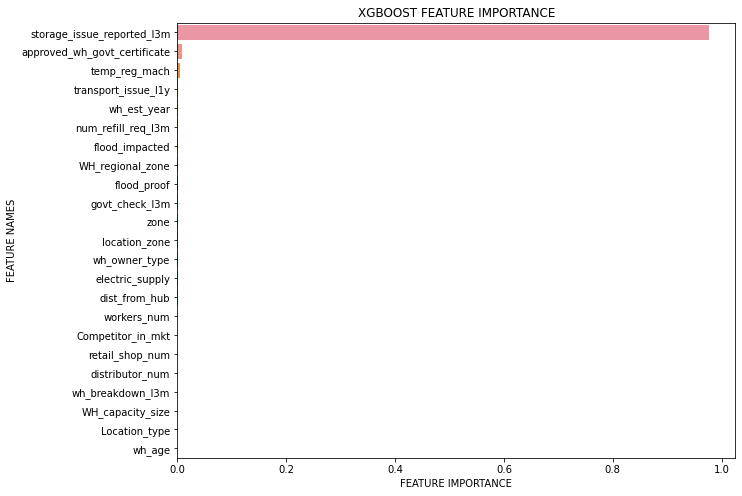

In [193]:
plot_feature_importance(xgb.feature_importances_,x_test.columns,'XGBOOST')

In [173]:
#Predicting with Random Forest Regressor

y_test_pred=rf.predict(x_test)
DF_y_test_pred=pd.DataFrame(y_test_pred,columns=['product_wg_ton_predict'])
x_test.reset_index(drop=True, inplace=True)
#y_test.reset_index(drop=True, inplace=True)
DF_y_test_pred.reset_index(drop=True, inplace=True)

Test_with_pred=pd.concat([x_test,DF_y_test_pred], axis=1)
Test_with_pred

,retail_shop_num,distributor_num,dist_from_hub,workers_num,wh_est_year,storage_issue_reported_l3m,govt_check_l3m,wh_age,Location_type,WH_capacity_size,...,Competitor_in_mkt,wh_owner_type,flood_impacted,flood_proof,electric_supply,temp_reg_mach,approved_wh_govt_certificate,wh_breakdown_l3m,location_zone,product_wg_ton_predict
0,5397,26,75,30,2019,9,29,3,0,0,...,1,0,0,0,1,1,0,1,1,12896.40
1,5183,61,138,20,2006,25,23,16,0,0,...,1,1,0,0,0,0,0,4,1,32006.89
2,4665,26,188,34,2005,24,23,17,0,0,...,3,1,0,0,1,0,2,4,1,28150.98
3,5196,36,156,31,2011,15,1,11,0,1,...,2,1,0,0,1,0,0,4,1,19818.68
4,8275,58,237,28,2007,21,12,15,0,1,...,3,1,0,0,1,1,3,2,1,25466.75
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2745,5390,19,142,34,2005,22,30,17,0,2,...,3,1,0,0,1,1,0,2,1,29694.26
2746,4490,57,130,28,2012,10,18,10,0,1,...,3,0,0,0,1,0,2,4,3,11807.22
2747,5403,31,147,28,2006,23,25,16,1,0,...,1,1,1,0,1,0,3,5,6,27251.40
2748,10562,25,60,25,2009,18,30,13,0,2,...,1,1,0,0,1,0,0,6,1,23662.03


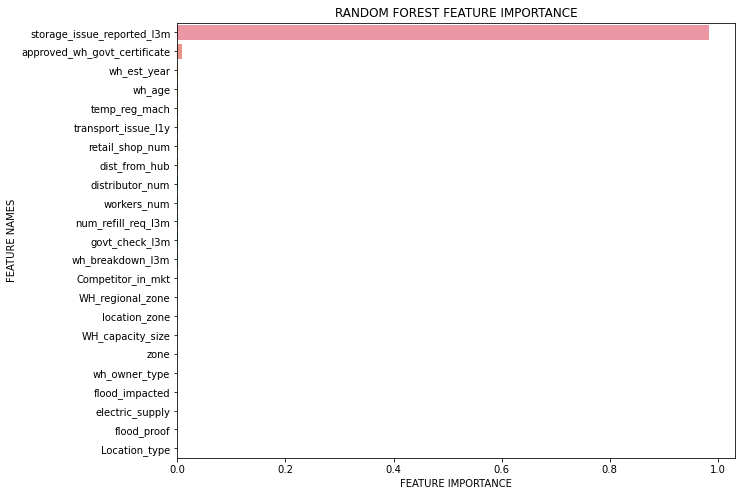

In [194]:
plot_feature_importance(rf.feature_importances_,x_test.columns,'RANDOM FOREST')

In [174]:
#Predicting with Gradient Boosting Regressor

y_test_pred=gb.predict(x_test)
DF_y_test_pred=pd.DataFrame(y_test_pred,columns=['product_wg_ton_predict'])
x_test.reset_index(drop=True, inplace=True)
#y_test.reset_index(drop=True, inplace=True)
DF_y_test_pred.reset_index(drop=True, inplace=True)

Test_with_pred=pd.concat([x_test,DF_y_test_pred], axis=1)
Test_with_pred

,retail_shop_num,distributor_num,dist_from_hub,workers_num,wh_est_year,storage_issue_reported_l3m,govt_check_l3m,wh_age,Location_type,WH_capacity_size,...,Competitor_in_mkt,wh_owner_type,flood_impacted,flood_proof,electric_supply,temp_reg_mach,approved_wh_govt_certificate,wh_breakdown_l3m,location_zone,product_wg_ton_predict
0,5397,26,75,30,2019,9,29,3,0,0,...,1,0,0,0,1,1,0,1,1,12823.615119
1,5183,61,138,20,2006,25,23,16,0,0,...,1,1,0,0,0,0,0,4,1,31361.087333
2,4665,26,188,34,2005,24,23,17,0,0,...,3,1,0,0,1,0,2,4,1,28598.107055
3,5196,36,156,31,2011,15,1,11,0,1,...,2,1,0,0,1,0,0,4,1,20076.737782
4,8275,58,237,28,2007,21,12,15,0,1,...,3,1,0,0,1,1,3,2,1,25852.424987
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2745,5390,19,142,34,2005,22,30,17,0,2,...,3,1,0,0,1,1,0,2,1,29789.727435
2746,4490,57,130,28,2012,10,18,10,0,1,...,3,0,0,0,1,0,2,4,3,12220.968168
2747,5403,31,147,28,2006,23,25,16,1,0,...,1,1,1,0,1,0,3,5,6,27859.928370
2748,10562,25,60,25,2009,18,30,13,0,2,...,1,1,0,0,1,0,0,6,1,23675.346709


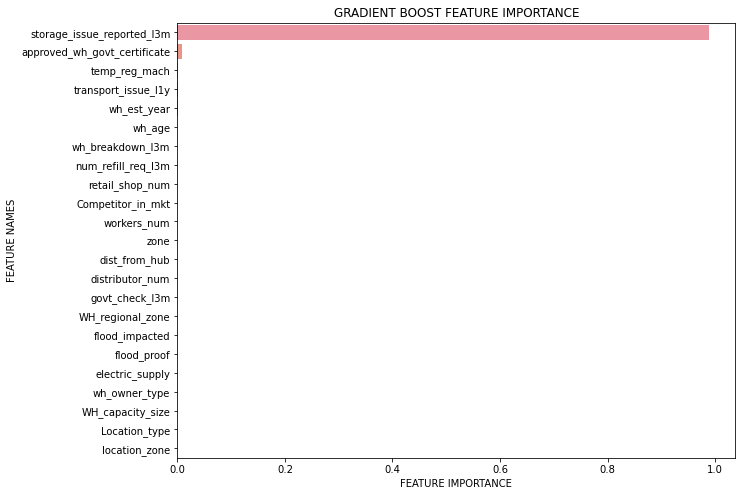

In [195]:
plot_feature_importance(gb.feature_importances_,x_test.columns,'GRADIENT BOOST')

### Conclusion

    1. The 3 top models from my analysis are Xgboost, Random Forest and Gradient Boosting
    2. The evaluation score for the three models averages 0.99 using the combination of rmse, adjusted R2, R2 and Cross validation metrics
    3. From the feature importance analysis, storage_issue_reported_l3m and approved_wh_govt_certificate features have shown to have contributed the highest to the prediction outcome

### Inferences

    1. Storage issues must have contributed most to the imbalance in the supply chain of the instant noodles
    2. Unapproved warehouses by the government may have also contributed to the imbalance in supply chain

### Recommendation

    1. Warehouses with storage issues should be fixed and attended to
    2. Unapproved warehouses should be certified by the government to avoid distruption in the supply chain management